In [1]:
# How do similar networks respond to FGSM Attacks from foolbox?
# Classic vs FGN vs Converted+trained

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8.0, 5.0)

In [4]:
import numpy as np

from foolbox import PyTorchModel, accuracy
import foolbox.attacks as fa
import foolbox as fb

import torch
from torch import optim

import copy

In [5]:
# custom library imports
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [6]:
# check gpus
!gpustat

countdown                      Mon May  2 00:10:22 2022  465.19.01
[0] NVIDIA GeForce RTX 2080 Ti | 53'C,   0 % |     4 / 11019 MB |
[1] NVIDIA GeForce RTX 2080 Ti | 52'C,   0 % |    21 / 11018 MB | root(16M)


In [7]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(1)

CUDA Available:  True
Using device: cuda


In [8]:
# get data 
(mnist_train_loader, mnist_val_loader, mnist_test_loader) = fgnh.mnist_dataloaders(batch_size=10000, 
                                                                                   batch_size_for_val=100000)

# minimum/maximum pixel value post normalization, from train dataset
min_pix = -0.4242129623889923095703125
max_pix =  2.8214867115020751953125000

images, labels = mnist_val_loader.dataset.tensors
images = images.to(device)
labels = labels.to(device)

In [9]:
for x,t in mnist_train_loader:
    break

In [10]:
t

tensor([8, 6, 5,  ..., 8, 7, 3])

In [11]:
# load classic model
classic_model_path = "../Experiments/sample_models/sample_classic_full.pth"
classic_model = torch.load(classic_model_path, map_location=torch.device(device))
# classic_model.to(device)

In [12]:
# classic model params
!cat '../Experiments/sample_models/sample_FGN_parameters.txt'

hidden_layer_sizes [64, 64]
drop_p 0.2
batch_size 4000
optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
ordinal 2.0
covar_type sphere
lambda for l2 loss 8e-06
lambda for sigma loss 1e-06
non-linearity True


In [13]:
# load an fgn model check same params as FGN
fgn_model_path = '../Experiments/sample_models/sample_FGN_full.pth'
fgn_model = torch.load(fgn_model_path, map_location=torch.device(device))
# fgn_model.to(device)

In [14]:
# convert model
fgnl.convert_classic_to_fgn(classic_model, fgn_model, init_factor=1e1, verbose=True)

odict_keys([])

Classic odict_keys(['hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weight', 'hidden_layers.4.bias', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_layers.5.running_mean', 'hidden_layers.5.running_var', 'hidden_layers.5.num_batches_tracked', 'ib.weight', 'ib.bias', 'ib.running_mean', 'ib.running_var', 'ib.num_batches_tracked', 'fl.weight', 'fl.bias'])
FGN odict_keys(['hidden_layers.1.weights', 'hidden_layers.1.biases', 'hidden_layers.1.centers', 'hidden_layers.1.inv_covars', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'hidden_layers.2.running_mean', 'hidden_layers.2.running_var', 'hidden_layers.2.num_batches_tracked', 'hidden_layers.4.weights', 'hidden_layers.4.biases', 'hidden_layers.4.centers', 'hidden_layers.4.inv_covars', 'hidden_layers.5.weight', 'hidden_layers.5.bias', 'hidden_la

/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/convert_classic_to_fgn.py:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  new_centers =  torch.Tensor([(-b/np.dot(x,x))*x for x,b in zip(weights.cpu().detach().numpy(), bias.cpu().detach().numpy())])


In [15]:
# do a quick retrain of the converted model
ret_quick_fgn_model = copy.deepcopy(fgn_model)
# ret_quick_fgn_model.to(device)

# define loss
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 1e-5
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# define optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, ret_quick_fgn_model.parameters()), lr=1e-3)

# train the network for N epochs
epochs = 1
train_res = fgnh.train(ret_quick_fgn_model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 1e-05
Epoch 0 Train set - Average loss: 1.5053, Accuracy: 48423/50000 (97%)
Test set - Average loss: 0.4354, Accuracy: 9749/10000 (97%)


In [16]:
# load heavily retrained model
ret_fgn_model_path = '../Experiments/sample_models/sample_fgn_converted+retrained_full.pth'
ret_fgn_model = torch.load(ret_fgn_model_path)
ret_fgn_model.to(device)

Feedforward_FGN_net(
  (hidden_layers): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): FGN_layer()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): FGN_layer()
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (ib): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): FGN_layer()
)

In [15]:
# # do a long retrain of the converted model
# ret_fgn_model= copy.deepcopy(fgn_model)

# # define loss
# lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
# lmbda_sigs = 1e-1
# print("lambda for l2 loss", lmbda_l2)
# print("lambda for sigs^2 loss", lmbda_sigs)

# cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

# # define optimizer
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, ret_fgn_model.parameters()), lr=1e-3)

# # train the network for N epochs
# epochs = 75
# train_res = fgnh.train(ret_fgn_model, mnist_train_loader, 
#                              cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
#                              pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_val_loader)

lambda for l2 loss 8e-06
lambda for sigs^2 loss 0.1
Epoch 0 Train set - Average loss: 19.6552, Accuracy: 49007/50000 (98%)
Test set - Average loss: 17.2235, Accuracy: 9777/10000 (98%)
Epoch 1 Train set - Average loss: 16.0251, Accuracy: 48945/50000 (98%)
Test set - Average loss: 14.4822, Accuracy: 9777/10000 (98%)
Epoch 2 Train set - Average loss: 13.6863, Accuracy: 48785/50000 (98%)
Test set - Average loss: 12.5986, Accuracy: 9770/10000 (98%)
Epoch 3 Train set - Average loss: 12.0511, Accuracy: 48587/50000 (97%)
Test set - Average loss: 11.2306, Accuracy: 9766/10000 (98%)
Epoch 4 Train set - Average loss: 10.8565, Accuracy: 48325/50000 (97%)
Test set - Average loss: 10.2000, Accuracy: 9763/10000 (98%)
Epoch 5 Train set - Average loss: 9.9614, Accuracy: 47880/50000 (96%)
Test set - Average loss: 9.4022, Accuracy: 9749/10000 (97%)
Epoch 6 Train set - Average loss: 9.2674, Accuracy: 47493/50000 (95%)
Test set - Average loss: 8.7696, Accuracy: 9738/10000 (97%)
Epoch 7 Train set - Average 

Epoch 63 Train set - Average loss: 2.8185, Accuracy: 48194/50000 (96%)
Test set - Average loss: 3.0715, Accuracy: 9716/10000 (97%)
Epoch 64 Train set - Average loss: 2.7893, Accuracy: 48217/50000 (96%)
Test set - Average loss: 3.0381, Accuracy: 9716/10000 (97%)
Epoch 65 Train set - Average loss: 2.7571, Accuracy: 48278/50000 (97%)
Test set - Average loss: 3.0116, Accuracy: 9720/10000 (97%)
Epoch 66 Train set - Average loss: 2.7284, Accuracy: 48243/50000 (96%)
Test set - Average loss: 2.9818, Accuracy: 9722/10000 (97%)
Epoch 67 Train set - Average loss: 2.7000, Accuracy: 48311/50000 (97%)
Test set - Average loss: 2.9542, Accuracy: 9726/10000 (97%)
Epoch 68 Train set - Average loss: 2.6727, Accuracy: 48270/50000 (97%)
Test set - Average loss: 2.9193, Accuracy: 9723/10000 (97%)
Epoch 69 Train set - Average loss: 2.6462, Accuracy: 48278/50000 (97%)
Test set - Average loss: 2.8901, Accuracy: 9724/10000 (97%)
Epoch 70 Train set - Average loss: 2.6166, Accuracy: 48296/50000 (97%)
Test set - A

In [19]:
# set model bounds and preprocessing

# bounds - I think these might be the bounds:
# inputs ? I think it this
# noise?
# bounds = (-(max_pix-min_pix)/128,(max_pix-min_pix)/128)
bounds = (min_pix+1e-6, max_pix-1e-6)
# preprocessing - I think these would be used in similar way to pytorch preprocessing
# but possible passed to whatever architecture is used (torch, tensorflow, other) 
# in my case the dataloaders already normalizes the data
preprocessing = dict(mean=0, std=1)

In [20]:
# ready the models for foolbox
classic_model.eval()
classic_f_model = PyTorchModel(classic_model, bounds=bounds, device=device)

fgn_model.eval()
fgn_f_model = PyTorchModel(fgn_model, bounds=bounds, device=device)

ret_quick_fgn_model.eval()
ret_quick_fgn_f_model = PyTorchModel(ret_quick_fgn_model, bounds=bounds, device=device)

ret_fgn_model.eval()
ret_fgn_f_model = PyTorchModel(ret_fgn_model, bounds=bounds, device=device)

In [21]:
ret_fgn_f_model.bounds

Bounds(lower=-0.42421196238899234, upper=2.821485711502075)

In [22]:
# check model accuracies
print('accuracies for classic and fgn models')
print(accuracy(classic_f_model, images, labels))
print(accuracy(fgn_f_model, images, labels))
print(accuracy(ret_quick_fgn_f_model, images, labels))
print(accuracy(ret_fgn_f_model, images, labels))

accuracies for classic and fgn models
0.9738999605178833
0.973800003528595
0.97489994764328
0.9805999994277954


In [23]:
# attack params to explore
epsilons = [(max_pix-min_pix)*x 
            for x in 
            [0.0,
             1/256,
             3/512,
             1/128,
             3/256,
             1/64,
             3/128,
             1/32,
             3/64,
             1/16,
             3/32,
             1/8,
             3/16,
             1/4,
             3/8,
             1/2,
             3/4,
             1.0,] ]

print('epsilons: {}'.format(epsilons))

epsilons: [0.0, 0.012678514351136982, 0.019017771526705474, 0.025357028702273965, 0.03803554305341095, 0.05071405740454793, 0.0760710861068219, 0.10142811480909586, 0.1521421722136438, 0.20285622961819172, 0.3042843444272876, 0.40571245923638344, 0.6085686888545752, 0.8114249184727669, 1.2171373777091503, 1.6228498369455338, 2.4342747554183006, 3.2456996738910675]


In [24]:
# attack the classic model
classic_raw, classic_clipped, classic_adv_success = fa.FGSM()(classic_f_model, images, labels, epsilons=epsilons)

In [25]:
# attack the converted fgn model
fgn_raw, fgn_clipped, fgn_adv_success = fa.FGSM()(fgn_f_model, images, labels, epsilons=epsilons)

In [26]:
# attack the quick retrained fgn model
ret_quick_fgn_raw, ret_quick_fgn_clipped, ret_quick_fgn_adv_success = fa.FGSM()(ret_quick_fgn_f_model, images, labels, epsilons=epsilons)

In [27]:
# attack the  long retrained fgn model
ret_fgn_raw, ret_fgn_clipped, ret_fgn_adv_success = fa.FGSM()(ret_fgn_f_model, images, labels, epsilons=epsilons)

In [52]:
results={}

In [53]:
results['classic_raw']=classic_raw
results['classic_clipped']=classic_clipped
results['classic_adv_success']=classic_adv_success

results['fgn_raw']=fgn_raw
results['fgn_clipped']=fgn_clipped
results['fgn_adv_success']=fgn_adv_success

results['ret_quick_fgn_raw']=ret_quick_fgn_raw
results['ret_quick_fgn_clipped']=ret_quick_fgn_clipped
results['ret_quick_fgn_adv_success']=ret_quick_fgn_adv_success

results['ret_fgn_raw']=ret_fgn_raw
results['ret_fgn_clipped']=ret_fgn_clipped
results['ret_fgn_adv_success']=ret_fgn_adv_success


In [57]:
import pickle

In [59]:
# save files separately
save_folder = '/scratch/felix/FGN---Results/MNIST-FGSM/'
for model in ['classic_', 'fgn_', 'ret_quick_fgn_', 'ret_fgn_']:
    for adv_name in ['raw', 'clipped', 'adv_success']:
        with open(save_folder+'{}.pickle'.format(model+adv_name), 'wb') as f:
            print(save_folder+'{}.pickle'.format(model+adv_name))
            pickle.dump(results[model+adv_name], f, protocol=4)

/scratch/felix/FGN---Results/MNIST-FGSM/classic_raw.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/classic_clipped.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/classic_adv_success.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/fgn_raw.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/fgn_clipped.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/fgn_adv_success.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/ret_quick_fgn_raw.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/ret_quick_fgn_clipped.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/ret_quick_fgn_adv_success.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/ret_fgn_raw.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/ret_fgn_clipped.pickle
/scratch/felix/FGN---Results/MNIST-FGSM/ret_fgn_adv_success.pickle


In [28]:
names = ['Classic', 'converted FGN', 'quick retrain FGN', 'long retrain FGN']

Classic Accuracy per epsilon [0.9739 0.1837 0.134  0.1102 0.0873 0.0783 0.0716 0.0673 0.0647 0.0633
 0.0623 0.0613 0.0614 0.0608 0.0605 0.0604 0.0605 0.0605]
FGN Accuracy per epsilon [0.9738 0.1836 0.1339 0.1096 0.087  0.0782 0.0707 0.0665 0.06   0.0736
 0.0804 0.0939 0.0756 0.0967 0.0967 0.0967 0.0967 0.1135]
Quick Retrained FGN Accuracy per epsilon [0.9749 0.1826 0.1351 0.1126 0.0887 0.0735 0.0934 0.0907 0.1029 0.0918
 0.0967 0.0967 0.0967 0.0967 0.0994 0.0991 0.0991 0.0991]
Long Retrained FGN Accuracy per epsilon [0.9806 0.101  0.0739 0.0991 0.0991 0.0991 0.0991 0.0991 0.0991 0.0991
 0.0991 0.0991 0.0991 0.0991 0.0991 0.0991 0.0991 0.0991]


<IPython.core.display.Javascript object>


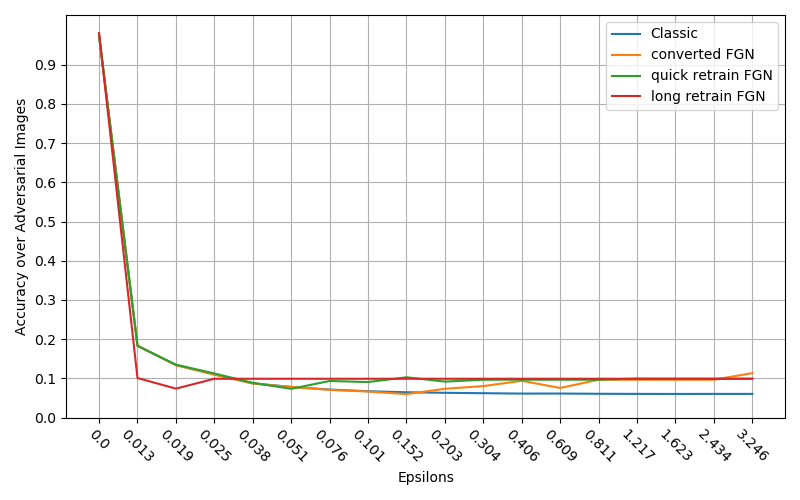

In [29]:
# compare raw success rates
print('Classic Accuracy per epsilon', 1.0 - classic_adv_success.cpu().numpy().mean(axis=-1))
print('FGN Accuracy per epsilon', 1.0 - fgn_adv_success.cpu().numpy().mean(axis=-1))
print('Quick Retrained FGN Accuracy per epsilon', 1.0 - ret_quick_fgn_adv_success.cpu().numpy().mean(axis=-1))
print('Long Retrained FGN Accuracy per epsilon', 1.0 - ret_fgn_adv_success.cpu().numpy().mean(axis=-1))

plt.plot(1.0 - classic_adv_success.cpu().numpy().mean(axis=-1), label=names[0])
plt.plot(1.0 - fgn_adv_success.cpu().numpy().mean(axis=-1), label=names[1])
plt.plot(1.0 - ret_quick_fgn_adv_success.cpu().numpy().mean(axis=-1), label=names[2])
plt.plot(1.0 - ret_fgn_adv_success.cpu().numpy().mean(axis=-1), label=names[3])
plt.legend()
plt.xticks(range(len(epsilons)), labels=np.round(epsilons,3), rotation=-45)
plt.xlabel('Epsilons')
plt.yticks([x/100 for x in range(0,100,10)])
plt.ylabel('Accuracy over Adversarial Images')
plt.tight_layout()
plt.grid()
plt.show()

In [30]:
# extract succesful adv indices
classic_successful_adv_indices = [np.flatnonzero(x) for x in classic_adv_success.cpu().numpy()]
fgn_successful_adv_indices = [np.flatnonzero(x) for x in fgn_adv_success.cpu().numpy()]
ret_quick_fgn_successful_adv_indices = [np.flatnonzero(x) for x in ret_quick_fgn_adv_success.cpu().numpy()]
ret_fgn_successful_adv_indices = [np.flatnonzero(x) for x in ret_fgn_adv_success.cpu().numpy()]

In [31]:
# extract succesful adv raw images
classic_raw_successful = [torch.stack([classic_raw[i][k] for k in j]) 
                          for i,j in enumerate(classic_successful_adv_indices)]
fgn_raw_successful = [torch.stack([fgn_raw[i][k] for k in j])
                      for i,j in enumerate(fgn_successful_adv_indices)]
ret_quick_fgn_raw_successful = [torch.stack([ret_quick_fgn_raw[i][k] for k in j])
                      for i,j in enumerate(ret_quick_fgn_successful_adv_indices)]
ret_fgn_raw_successful = [torch.stack([ret_fgn_raw[i][k] for k in j])
                      for i,j in enumerate(ret_fgn_successful_adv_indices)]

In [32]:
# per epsilon, number of attacks that both:
#  - change the class
#  - have over 0.5 confidence

per_epsilon = []

for i, clipped_images in enumerate(zip(classic_raw_successful, fgn_raw_successful, 
                                       ret_quick_fgn_raw_successful, ret_fgn_raw_successful)):
    
    per_model = [] 
    for n, model in enumerate([classic_model, fgn_model, ret_quick_fgn_model, ret_fgn_model]):
        
        # compute predictions
        model.eval()
        with torch.no_grad(): preds = model(clipped_images[n].to(device))
        preds = preds.cpu().detach().numpy()
        
        # apply softmax for probabilities
        preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])
        # get the maximums
        preds_maxes = np.max(preds_softmax, axis=1)
        
        per_model.append(len([x for x in preds_maxes if x>=0.5 ]))
    per_epsilon.append(per_model)

In [33]:
l = list(zip(*per_epsilon))

In [34]:
np.reshape(l, (3,-1))

array([[ 242, 7463, 7934, 8244, 8584, 8728, 8814, 8846, 8878, 8895, 8878,
        8887, 8901, 8911, 8922, 8926, 8929, 8933,  241, 7441, 7903, 8204,
        8532, 8669],
       [8584, 8457, 7224,  388,    1,    0,    0,    0,    0,    0,    0,
           0,  218, 7245, 7550, 7643, 7122, 5096,   18,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,  172,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]])

<IPython.core.display.Javascript object>


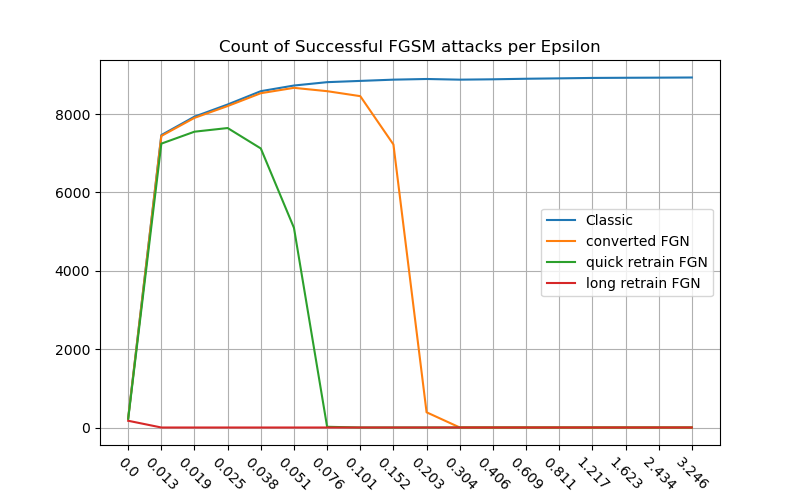

In [36]:
for n, p in enumerate(l):
    plt.plot(p, label=names[n])

plt.legend()
plt.grid()
plt.title('Count of Successful FGSM attacks per Epsilon')
plt.xticks(range(len(epsilons)), labels=np.round(epsilons,3), rotation=-45)
plt.show()

<IPython.core.display.Javascript object>


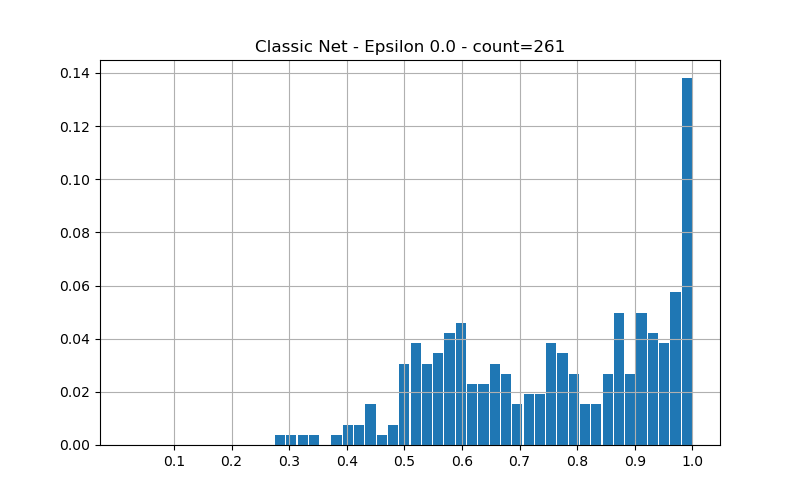

Statistical description of the predictions maximums
DescribeResult(nobs=261, minmax=(0.29110096055812456883, 0.999603761758864182), mean=0.759907630853898961, variance=0.03465638522439694262, skewness=-0.33914351168596709198, kurtosis=-1.0657858272436174285)

percentage of confident predictions (>=0.5): 0.9272030651340997

Sample predictions
index 16 prediction [0.   0.   0.   0.25 0.   0.25 0.   0.   0.43 0.07]
index 114 prediction [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
index 153 prediction [0.   0.   0.   0.02 0.01 0.01 0.   0.07 0.02 0.87]
index 81 prediction [0.   0.02 0.   0.   0.   0.   0.98 0.   0.   0.  ]
index 129 prediction [0.   0.   0.   0.   0.   0.   0.   0.11 0.   0.88]


<IPython.core.display.Javascript object>


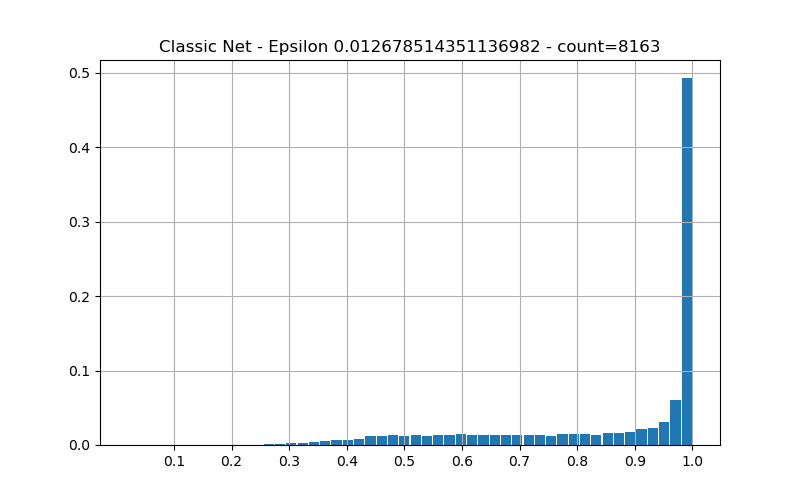

Statistical description of the predictions maximums
DescribeResult(nobs=8163, minmax=(0.24234768043920759258, 0.9998696785042729198), mean=0.8580919992502786127, variance=0.037384000060080048915, skewness=-1.2283773405908672792, kurtosis=0.18209270246409437789)

percentage of confident predictions (>=0.5): 0.9142472130344236

Sample predictions
index 7983 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4868 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4713 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 2345 prediction [0.   0.3  0.   0.04 0.   0.   0.57 0.   0.08 0.  ]
index 1457 prediction [0.   0.   0.   0.01 0.   0.   0.   0.   0.97 0.01]


<IPython.core.display.Javascript object>


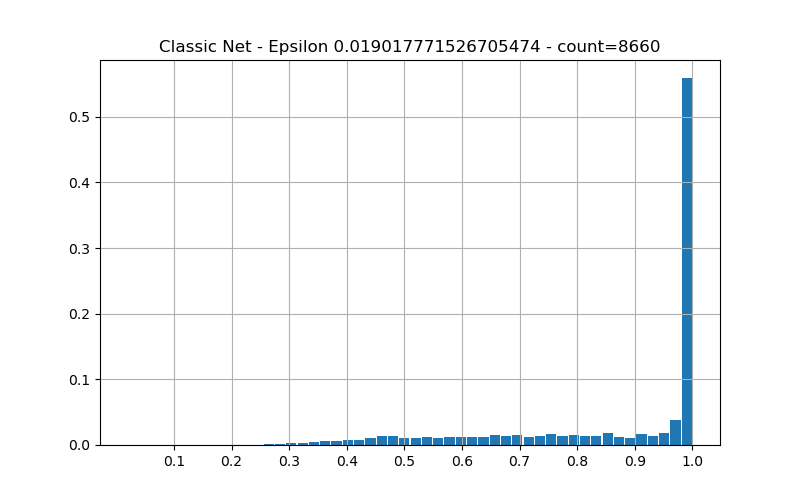

Statistical description of the predictions maximums
DescribeResult(nobs=8660, minmax=(0.21723404583009315073, 0.9996466357575591912), mean=0.865711156205615209, variance=0.03714542724687665736, skewness=-1.2944604948902718365, kurtosis=0.373100559476697015)

percentage of confident predictions (>=0.5): 0.9161662817551963

Sample predictions
index 7615 prediction [0.   0.06 0.05 0.06 0.   0.78 0.   0.05 0.   0.  ]
index 5020 prediction [0.   0.03 0.02 0.03 0.   0.04 0.   0.86 0.   0.01]
index 6510 prediction [0.   0.   0.   0.05 0.   0.   0.   0.   0.95 0.  ]
index 2413 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 264 prediction [0.   0.07 0.02 0.09 0.   0.09 0.   0.71 0.   0.01]


<IPython.core.display.Javascript object>


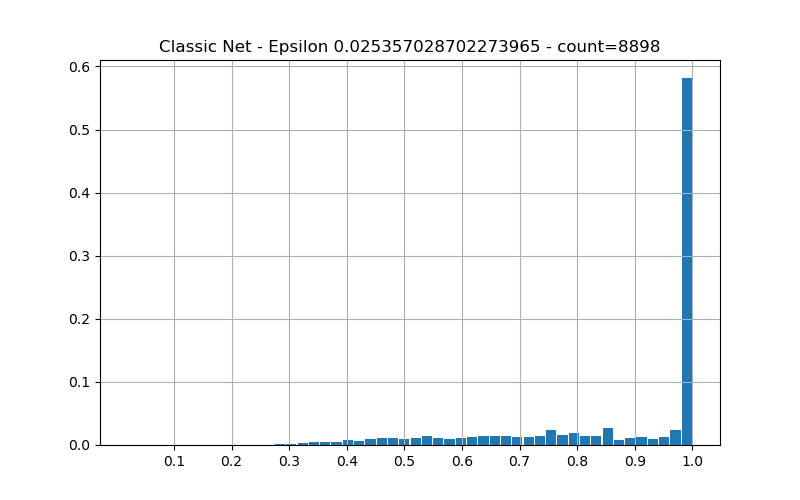

Statistical description of the predictions maximums
DescribeResult(nobs=8898, minmax=(0.2515901398730909135, 0.9997198960774558207), mean=0.86960573141234153577, variance=0.03567669334541384203, skewness=-1.3183479239040690251, kurtosis=0.50287090815956486407)

percentage of confident predictions (>=0.5): 0.9265003371544167

Sample predictions
index 7466 prediction [0.   0.11 0.07 0.1  0.   0.16 0.   0.56 0.   0.  ]
index 8538 prediction [0.01 0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 915 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8568 prediction [0.01 0.   0.   0.09 0.01 0.   0.01 0.02 0.85 0.01]
index 8588 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


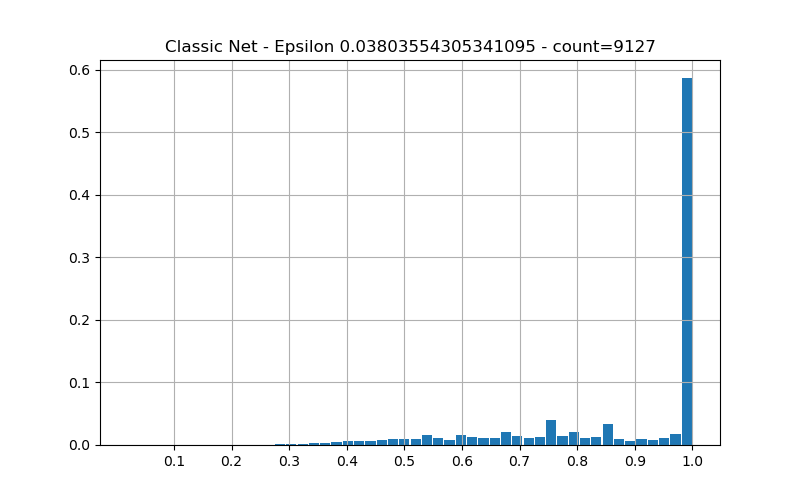

Statistical description of the predictions maximums
DescribeResult(nobs=9127, minmax=(0.23718661536896613347, 0.9998641336219939614), mean=0.8736071174195892469, variance=0.032887829109178230047, skewness=-1.2972795564448845656, kurtosis=0.52301893476590362287)

percentage of confident predictions (>=0.5): 0.9405061904240166

Sample predictions
index 5936 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4632 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2917 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 448 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8463 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


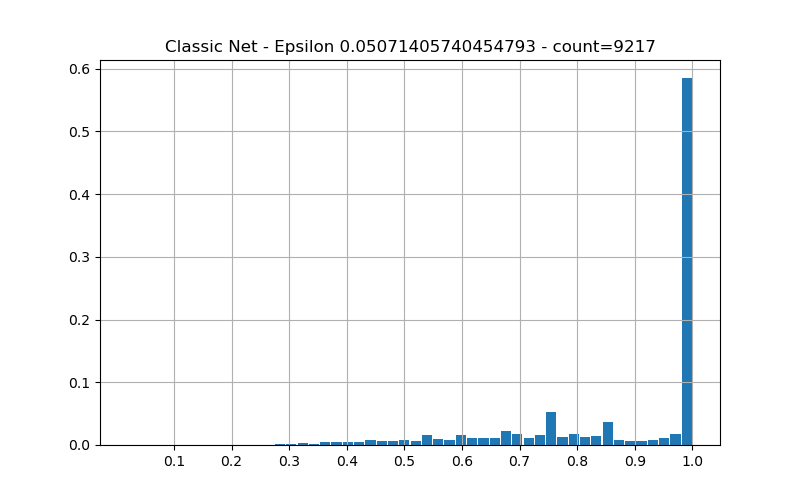

Statistical description of the predictions maximums
DescribeResult(nobs=9217, minmax=(0.24377941721992412072, 0.9997869626186972258), mean=0.87574542925211987883, variance=0.03141470054642866523, skewness=-1.3078669308292779519, kurtosis=0.64713963330902332075)

percentage of confident predictions (>=0.5): 0.9469458609091895

Sample predictions
index 7438 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8996 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5409 prediction [0.   0.   0.   0.   0.11 0.03 0.45 0.   0.41 0.  ]
index 69 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4037 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]


<IPython.core.display.Javascript object>


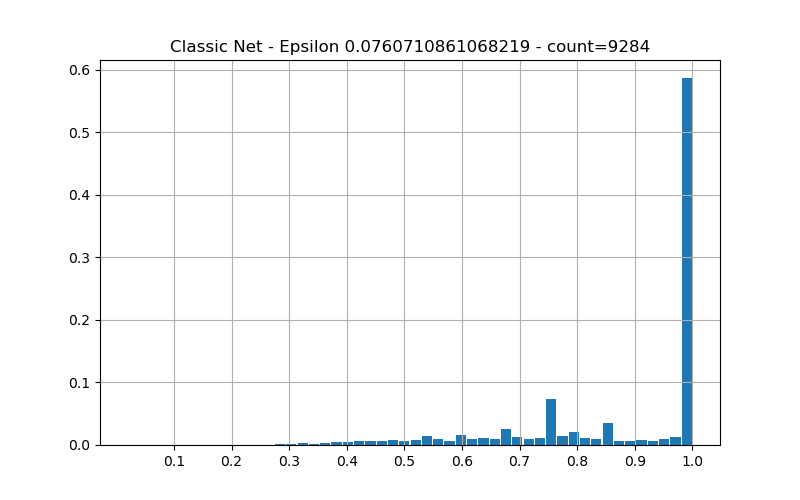

Statistical description of the predictions maximums
DescribeResult(nobs=9284, minmax=(0.21190663037695941828, 0.9998620506886740955), mean=0.87646791539986819116, variance=0.030683420501242093178, skewness=-1.3046060689591631024, kurtosis=0.68954386528301702926)

percentage of confident predictions (>=0.5): 0.9493752692804825

Sample predictions
index 1064 prediction [0.   0.   0.   0.81 0.   0.   0.   0.17 0.   0.01]
index 6859 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 5404 prediction [0.   0.01 0.02 0.72 0.01 0.   0.   0.11 0.03 0.1 ]
index 5277 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2190 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


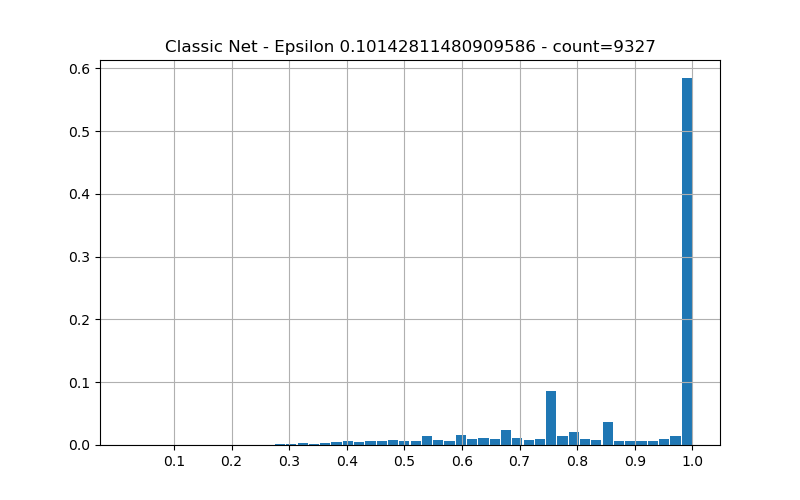

Statistical description of the predictions maximums
DescribeResult(nobs=9327, minmax=(0.20483571977586902805, 0.99986937928846315556), mean=0.8760466830517345708, variance=0.030690300024002634941, skewness=-1.3126308561856367102, kurtosis=0.75851704382659374264)

percentage of confident predictions (>=0.5): 0.948429291304814

Sample predictions
index 7894 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1005 prediction [0.   0.03 0.03 0.05 0.   0.01 0.   0.87 0.   0.01]
index 2143 prediction [0.   0.13 0.13 0.06 0.   0.07 0.   0.61 0.   0.  ]
index 8545 prediction [0.   0.01 0.55 0.3  0.   0.03 0.   0.11 0.   0.  ]
index 3488 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


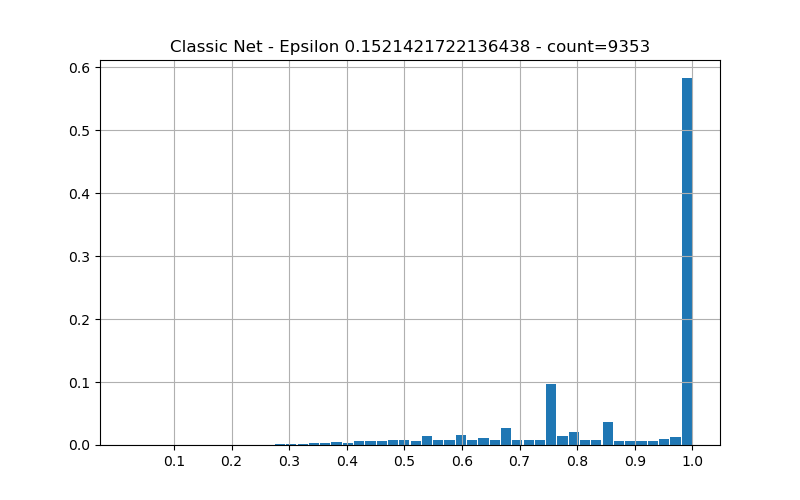

Statistical description of the predictions maximums
DescribeResult(nobs=9353, minmax=(0.23999853848147466523, 0.99986910009742581217), mean=0.87546439300059627076, variance=0.03042756081541298525, skewness=-1.2800746373931807443, kurtosis=0.64777924798522512726)

percentage of confident predictions (>=0.5): 0.949214155885812

Sample predictions
index 440 prediction [0.01 0.   0.   0.   0.   0.   0.41 0.   0.57 0.  ]
index 7735 prediction [0.   0.03 0.02 0.06 0.   0.08 0.   0.8  0.   0.01]
index 3795 prediction [0.01 0.03 0.42 0.02 0.   0.13 0.07 0.33 0.   0.  ]
index 5475 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7657 prediction [0.   0.06 0.09 0.06 0.   0.1  0.   0.69 0.   0.  ]


<IPython.core.display.Javascript object>


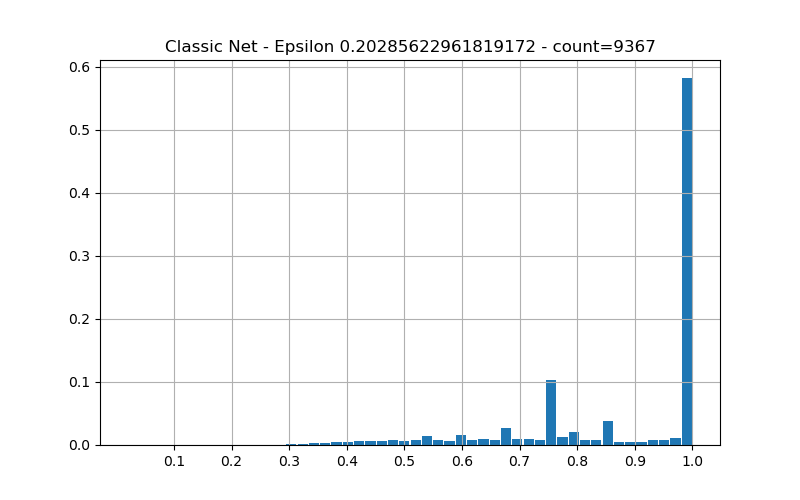

Statistical description of the predictions maximums
DescribeResult(nobs=9367, minmax=(0.22892531334296254072, 0.99986718996667803006), mean=0.8753712849147607945, variance=0.030260116191127390489, skewness=-1.271581417996533322, kurtosis=0.6265446998581069883)

percentage of confident predictions (>=0.5): 0.9496103341518095

Sample predictions
index 7829 prediction [0.   0.07 0.05 0.09 0.   0.1  0.   0.68 0.   0.  ]
index 760 prediction [0.   0.03 0.02 0.03 0.   0.04 0.   0.86 0.   0.01]
index 2708 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2360 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.01]
index 2185 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


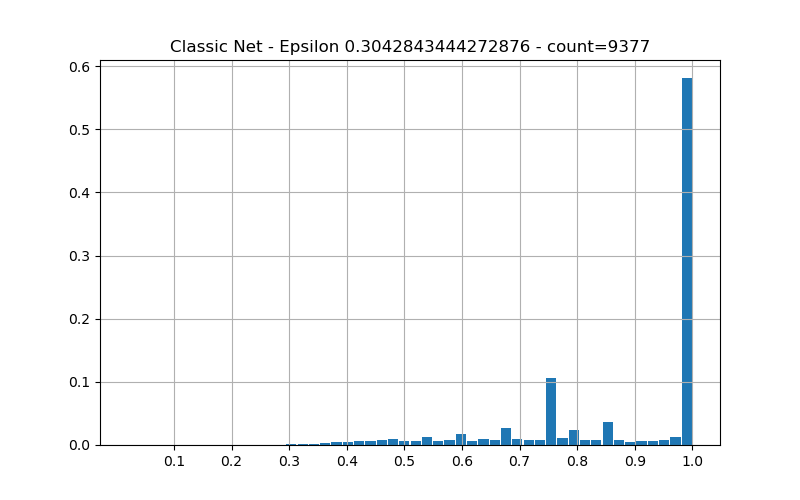

Statistical description of the predictions maximums
DescribeResult(nobs=9377, minmax=(0.21755799265924914838, 0.9998334718378875627), mean=0.87505907459540943464, variance=0.03036739191809849323, skewness=-1.2785782423438839174, kurtosis=0.66714982833101747696)

percentage of confident predictions (>=0.5): 0.9467846859336675

Sample predictions
index 8613 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 2458 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 1530 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8983 prediction [0.01 0.01 0.   0.02 0.02 0.78 0.05 0.   0.09 0.03]
index 7480 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


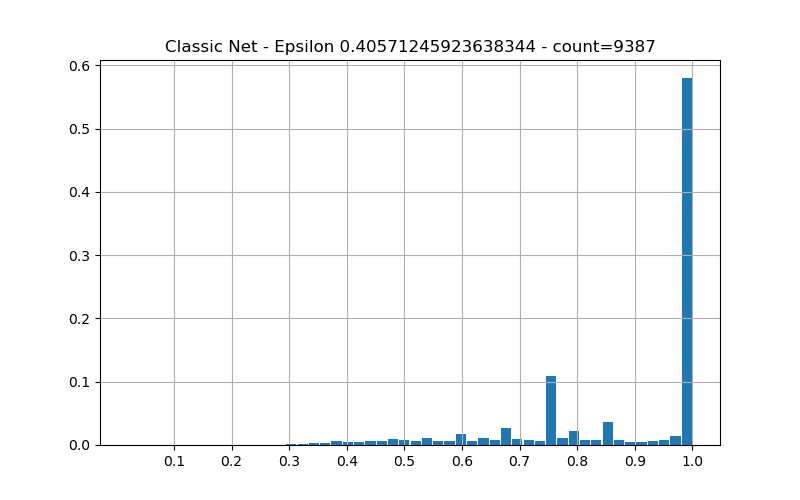

Statistical description of the predictions maximums
DescribeResult(nobs=9387, minmax=(0.21249848943497543857, 0.99976881584609361854), mean=0.87475447021030742876, variance=0.030458965371805900834, skewness=-1.2780448534888570078, kurtosis=0.6647479850144941461)

percentage of confident predictions (>=0.5): 0.9467348460637052

Sample predictions
index 4731 prediction [0.   0.38 0.02 0.1  0.   0.06 0.   0.43 0.   0.01]
index 1369 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.01]
index 2957 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4768 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6379 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


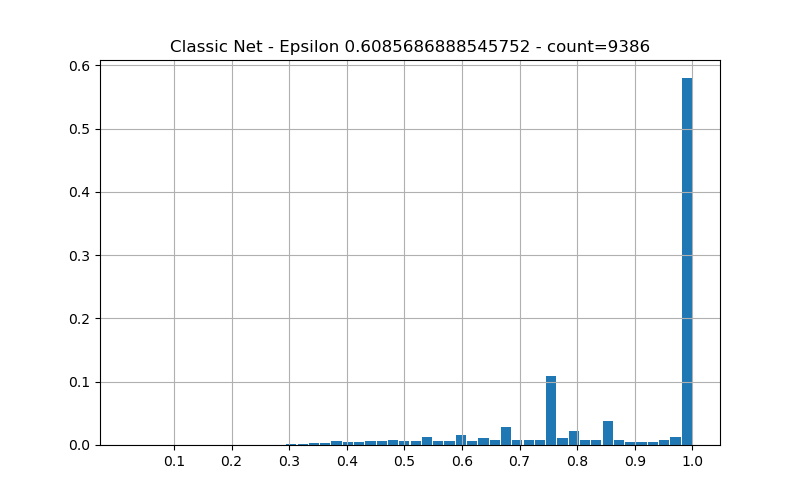

Statistical description of the predictions maximums
DescribeResult(nobs=9386, minmax=(0.24164235556544975634, 0.9997094826847329876), mean=0.875445842813425472, variance=0.03009309378100562109, skewness=-1.2807368231202874359, kurtosis=0.6815740364487569824)

percentage of confident predictions (>=0.5): 0.9483272959727254

Sample predictions
index 1066 prediction [0.   0.06 0.04 0.09 0.   0.16 0.   0.64 0.   0.  ]
index 5026 prediction [0.   0.03 0.02 0.03 0.   0.04 0.   0.86 0.   0.01]
index 364 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1066 prediction [0.   0.06 0.04 0.09 0.   0.16 0.   0.64 0.   0.  ]
index 514 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


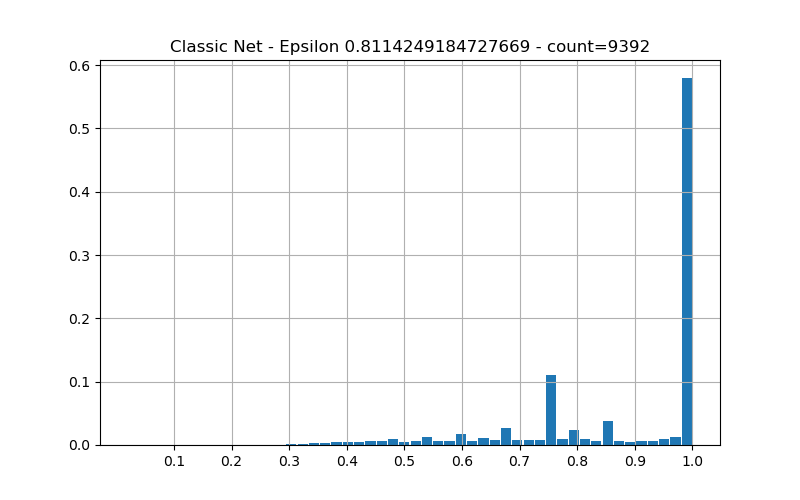

Statistical description of the predictions maximums
DescribeResult(nobs=9392, minmax=(0.24014931990536054823, 0.9995791208079988533), mean=0.8756965068529775477, variance=0.029909897048763905228, skewness=-1.2789352929303683205, kurtosis=0.6788964396287618709)

percentage of confident predictions (>=0.5): 0.9487862010221465

Sample predictions
index 8447 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 4123 prediction [0.   0.   0.   0.   0.   0.01 0.   0.   0.98 0.  ]
index 7996 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 9237 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2816 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


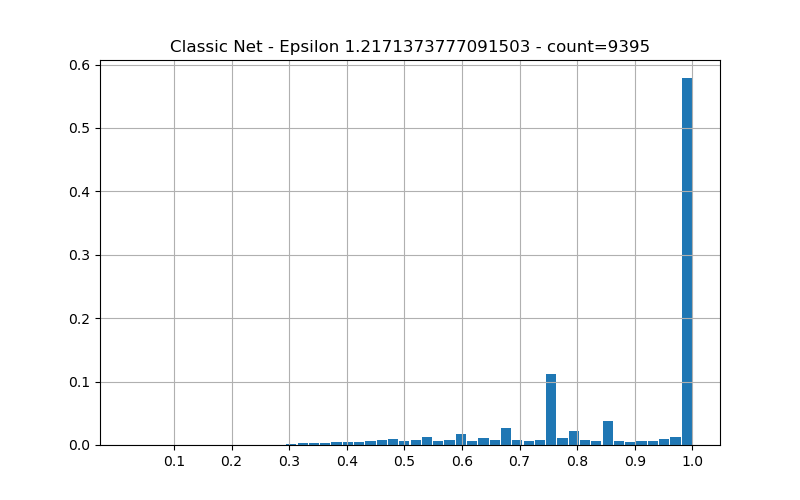

Statistical description of the predictions maximums
DescribeResult(nobs=9395, minmax=(0.24164235556544975634, 0.99951060579498728824), mean=0.8757817985953265933, variance=0.029784315312527306204, skewness=-1.2720554977228246264, kurtosis=0.6537369875333245159)

percentage of confident predictions (>=0.5): 0.9496540713145291

Sample predictions
index 2710 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8931 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8573 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6406 prediction [0.   0.   0.   0.   0.   0.01 0.   0.   0.98 0.  ]
index 603 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


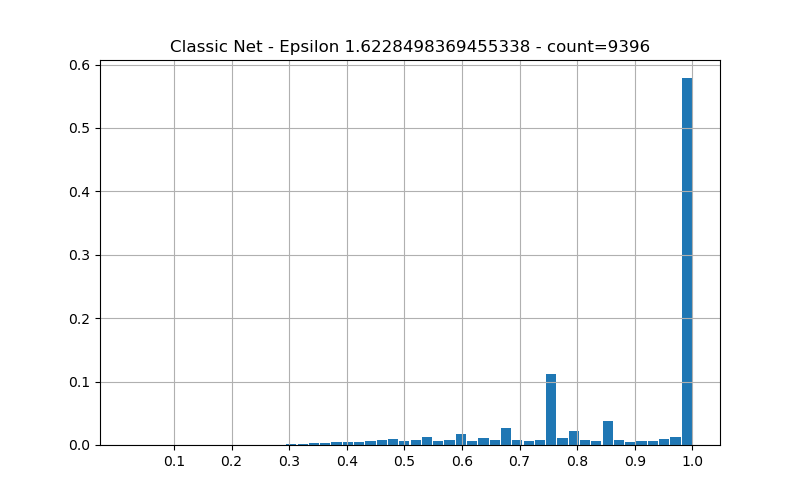

Statistical description of the predictions maximums
DescribeResult(nobs=9396, minmax=(0.24164235556544975634, 0.99951060579498728824), mean=0.87576389505810818336, variance=0.029691502509756630002, skewness=-1.2640161661720065106, kurtosis=0.62271217000472005505)

percentage of confident predictions (>=0.5): 0.9499787143465305

Sample predictions
index 8192 prediction [0.   0.15 0.2  0.19 0.   0.24 0.   0.22 0.   0.  ]
index 3027 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 483 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2288 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5614 prediction [0.   0.14 0.04 0.08 0.   0.26 0.   0.47 0.   0.01]


<IPython.core.display.Javascript object>


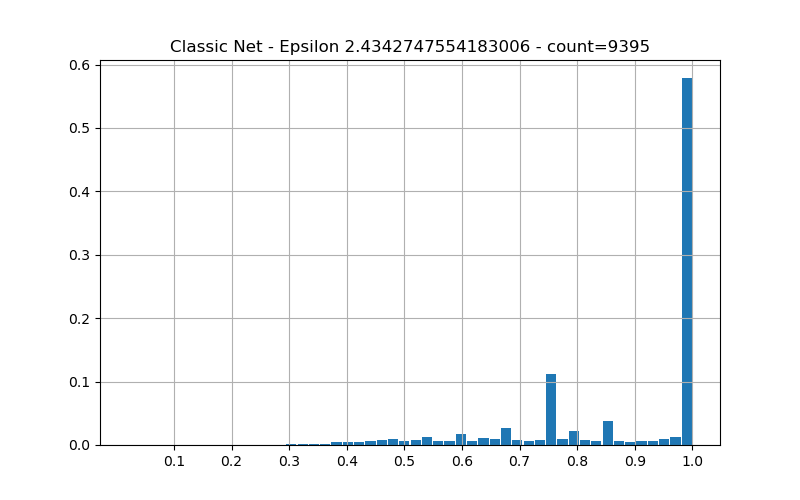

Statistical description of the predictions maximums
DescribeResult(nobs=9395, minmax=(0.22862906745856154266, 0.99951060579498728824), mean=0.87598229159490492967, variance=0.029589199203721042989, skewness=-1.2665728177265801826, kurtosis=0.64215769288829465246)

percentage of confident predictions (>=0.5): 0.9503991484832358

Sample predictions
index 8180 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8124 prediction [0.   0.19 0.15 0.08 0.   0.07 0.   0.5  0.   0.  ]
index 4748 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 214 prediction [0.   0.03 0.06 0.05 0.   0.1  0.   0.75 0.   0.  ]
index 206 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


/home/felix/Research/Adversarial Research/FGN---Research/Finite_Gaussian_Network_lib/fgn_helper_lib/plot_pred_histogram.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.hist(preds_maxes, bins=(np.arange(51)+1)/51.0, rwidth=0.9, align='mid', weights=weights)


<IPython.core.display.Javascript object>


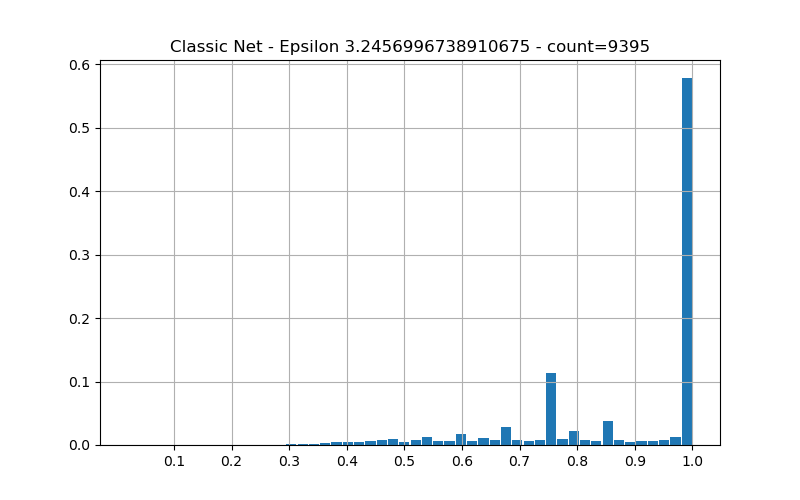

Statistical description of the predictions maximums
DescribeResult(nobs=9395, minmax=(0.22862325525895203329, 0.99951060579498728824), mean=0.8760283620657085568, variance=0.029531305350241492914, skewness=-1.2653223714079244868, kurtosis=0.638854366121123492)

percentage of confident predictions (>=0.5): 0.9508249068653539

Sample predictions
index 559 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 6887 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4551 prediction [0.   0.03 0.01 0.03 0.   0.01 0.   0.92 0.   0.  ]
index 5343 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1391 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


In [37]:
# rerun the classic model on adv examples
for i ,classic_raw_images in enumerate(classic_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(classic_raw_images))
    t = 'Classic Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(classic_model, dl, title=t, verbose=True)

<IPython.core.display.Javascript object>


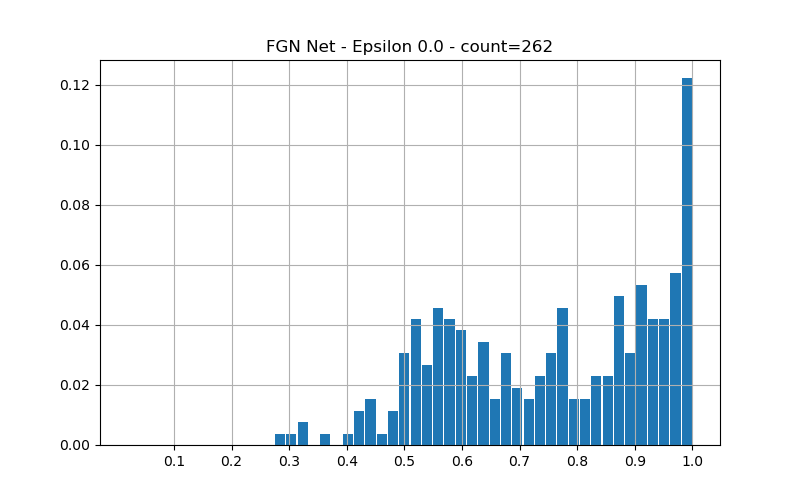

Statistical description of the predictions maximums
DescribeResult(nobs=262, minmax=(0.2911989091668304534, 0.99955583239725895176), mean=0.7559467021837770353, variance=0.034891598853004100856, skewness=-0.31839420796062341122, kurtosis=-1.0829179536866666221)

percentage of confident predictions (>=0.5): 0.9198473282442748

Sample predictions
index 110 prediction [0.   0.   0.   0.64 0.   0.35 0.   0.   0.   0.  ]
index 12 prediction [0.88 0.   0.   0.   0.   0.   0.   0.05 0.   0.06]
index 123 prediction [0.   0.   0.   0.   0.   0.   0.01 0.   0.9  0.09]
index 211 prediction [0.05 0.   0.   0.   0.   0.   0.94 0.   0.   0.  ]
index 69 prediction [0.   0.   0.23 0.1  0.61 0.   0.03 0.   0.03 0.  ]


<IPython.core.display.Javascript object>


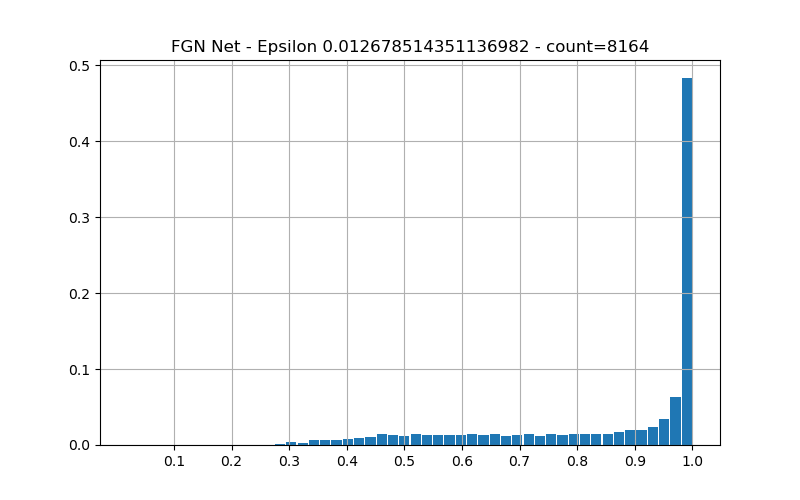

Statistical description of the predictions maximums
DescribeResult(nobs=8164, minmax=(0.24075407729570858008, 0.9997280487488243841), mean=0.8549398122803618219, variance=0.038207896774579622266, skewness=-1.204465312670666828, kurtosis=0.107590334839479132836)

percentage of confident predictions (>=0.5): 0.9114404703576678

Sample predictions
index 6719 prediction [0.06 0.   0.   0.   0.   0.   0.01 0.   0.93 0.  ]
index 2645 prediction [0.   0.   0.37 0.61 0.   0.01 0.   0.   0.   0.  ]
index 2301 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 685 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4130 prediction [0.   0.13 0.14 0.1  0.   0.34 0.   0.28 0.   0.  ]


<IPython.core.display.Javascript object>


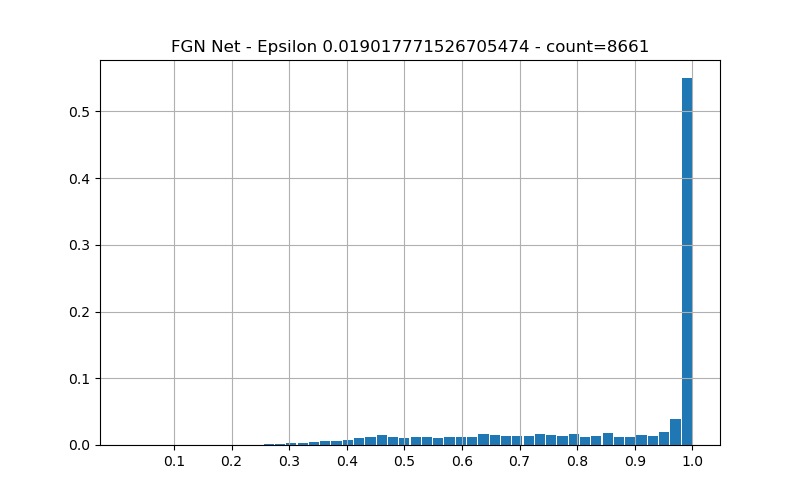

Statistical description of the predictions maximums
DescribeResult(nobs=8661, minmax=(0.21776820085215297237, 0.9997072865513459619), mean=0.86179121600670569237, variance=0.03810701337601348802, skewness=-1.255257620225889315, kurtosis=0.2537993773671500114)

percentage of confident predictions (>=0.5): 0.9124812377323634

Sample predictions
index 1882 prediction [0.   0.06 0.08 0.09 0.   0.61 0.03 0.14 0.   0.  ]
index 3203 prediction [0.   0.04 0.05 0.02 0.   0.13 0.   0.76 0.   0.  ]
index 1383 prediction [0.   0.04 0.02 0.03 0.   0.04 0.   0.86 0.   0.01]
index 6790 prediction [0.01 0.   0.   0.03 0.   0.01 0.   0.   0.95 0.  ]
index 7702 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


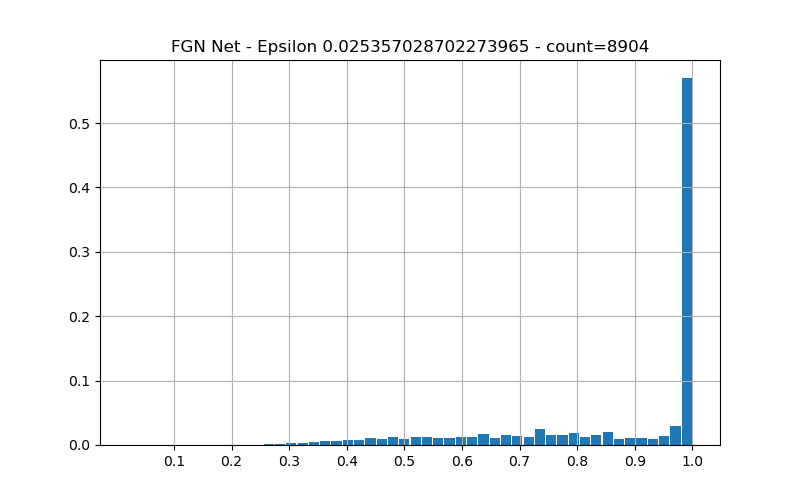

Statistical description of the predictions maximums
DescribeResult(nobs=8904, minmax=(0.23814277898118661103, 0.99964347887199970106), mean=0.8645733241563379177, variance=0.037002678926520313015, skewness=-1.2677874317869004659, kurtosis=0.34546334440563202634)

percentage of confident predictions (>=0.5): 0.9213836477987422

Sample predictions
index 5107 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3648 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 2472 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 7308 prediction [0.   0.02 0.03 0.04 0.   0.28 0.   0.63 0.   0.01]
index 8549 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


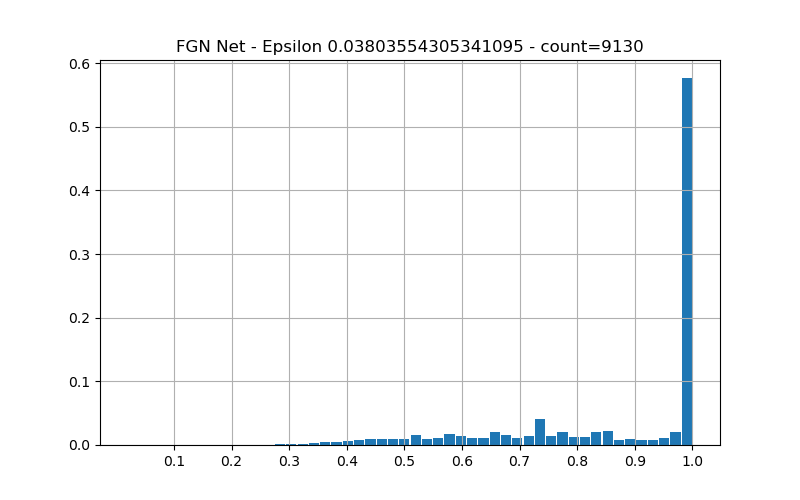

Statistical description of the predictions maximums
DescribeResult(nobs=9130, minmax=(0.22927255353503785219, 0.99978671504554798), mean=0.86553617625610376583, variance=0.03489825662976530943, skewness=-1.2079442896311811641, kurtosis=0.22389852655108165801)

percentage of confident predictions (>=0.5): 0.9345016429353779

Sample predictions
index 6548 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 4088 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 8645 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 347 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 4192 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


<IPython.core.display.Javascript object>


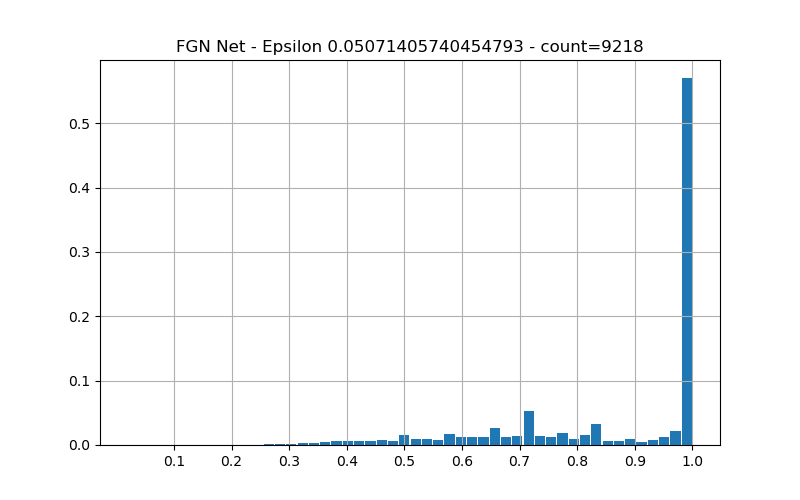

Statistical description of the predictions maximums
DescribeResult(nobs=9218, minmax=(0.24648184967235490454, 0.9997864308144771349), mean=0.8630944770082467335, variance=0.03460694598900581298, skewness=-1.174784682442528068, kurtosis=0.19259334066719271082)

percentage of confident predictions (>=0.5): 0.9404426122803211

Sample predictions
index 7745 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 4234 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 1634 prediction [0.   0.04 0.04 0.04 0.   0.07 0.   0.81 0.   0.01]
index 8242 prediction [0.   0.02 0.05 0.05 0.   0.16 0.   0.7  0.   0.  ]
index 1229 prediction [0.   0.04 0.07 0.04 0.   0.13 0.   0.71 0.   0.  ]


<IPython.core.display.Javascript object>


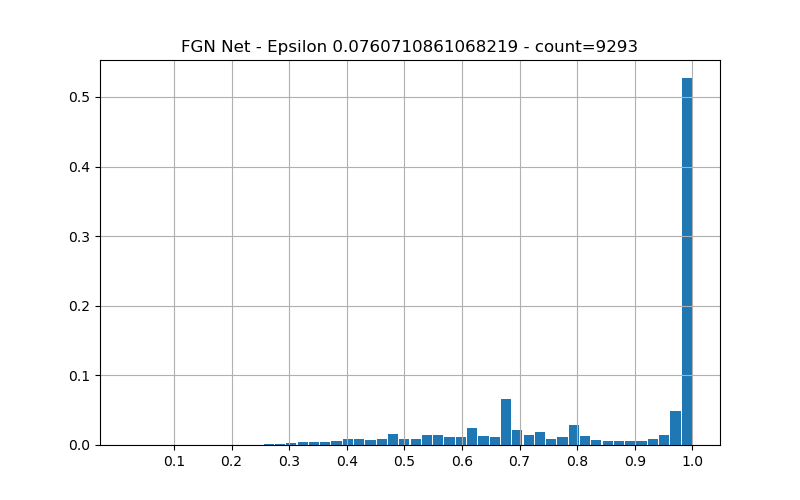

Statistical description of the predictions maximums
DescribeResult(nobs=9293, minmax=(0.22240912688520628528, 0.99940187908586869045), mean=0.84770497862944680186, variance=0.037431815694856431558, skewness=-1.0344067961330759193, kurtosis=-0.20348432260731053565)

percentage of confident predictions (>=0.5): 0.9237060152803185

Sample predictions
index 5817 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 6346 prediction [0.   0.   0.   0.01 0.   0.01 0.   0.   0.97 0.01]
index 7366 prediction [0.07 0.02 0.   0.56 0.   0.16 0.   0.04 0.05 0.09]
index 3689 prediction [0.   0.04 0.05 0.04 0.   0.01 0.   0.85 0.   0.01]
index 5515 prediction [0.   0.08 0.06 0.11 0.   0.12 0.   0.63 0.   0.01]


<IPython.core.display.Javascript object>


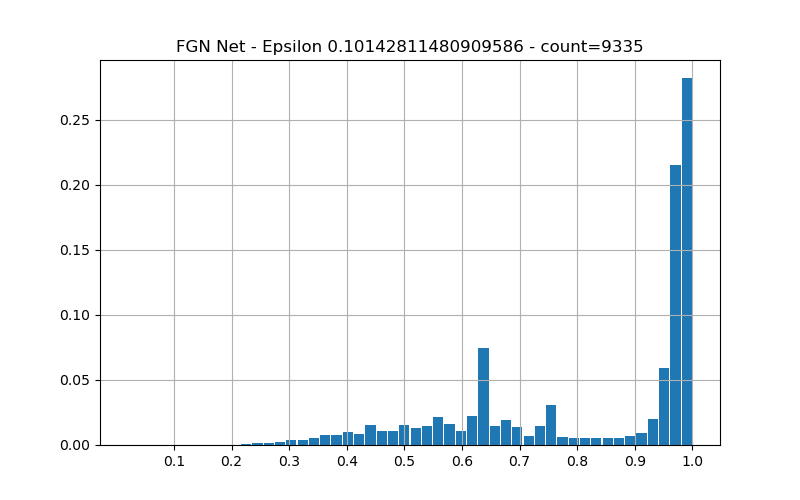

Statistical description of the predictions maximums
DescribeResult(nobs=9335, minmax=(0.20798254989765030596, 0.99833735659115573573), mean=0.8197799766427231738, variance=0.041404801570151971424, skewness=-0.87695599731888628517, kurtosis=-0.61013368473039689154)

percentage of confident predictions (>=0.5): 0.905945366898768

Sample predictions
index 4589 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 7500 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 6353 prediction [0.   0.05 0.09 0.08 0.   0.13 0.   0.64 0.   0.01]
index 1034 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 7736 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


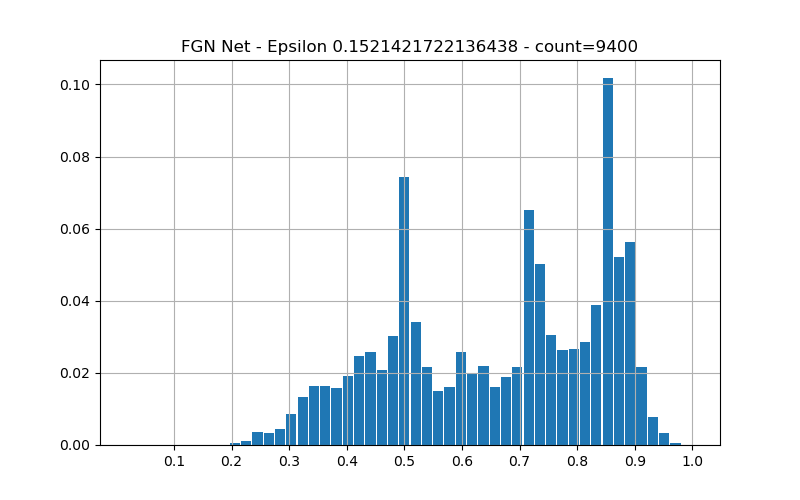

Statistical description of the predictions maximums
DescribeResult(nobs=9400, minmax=(0.17568321759853102566, 0.98717844960871878747), mean=0.66337109648322714915, variance=0.032971230881115195304, skewness=-0.35113361508858745232, kurtosis=-1.1002622935568497794)

percentage of confident predictions (>=0.5): 0.7685106382978724

Sample predictions
index 1139 prediction [0.   0.13 0.14 0.11 0.   0.18 0.01 0.42 0.   0.01]
index 9031 prediction [0.   0.07 0.11 0.12 0.01 0.16 0.   0.51 0.   0.01]
index 7726 prediction [0.   0.1  0.09 0.2  0.01 0.24 0.01 0.33 0.   0.01]
index 8893 prediction [0.   0.07 0.11 0.12 0.01 0.16 0.   0.51 0.   0.01]
index 9314 prediction [0.   0.07 0.11 0.12 0.01 0.16 0.   0.52 0.   0.01]


<IPython.core.display.Javascript object>


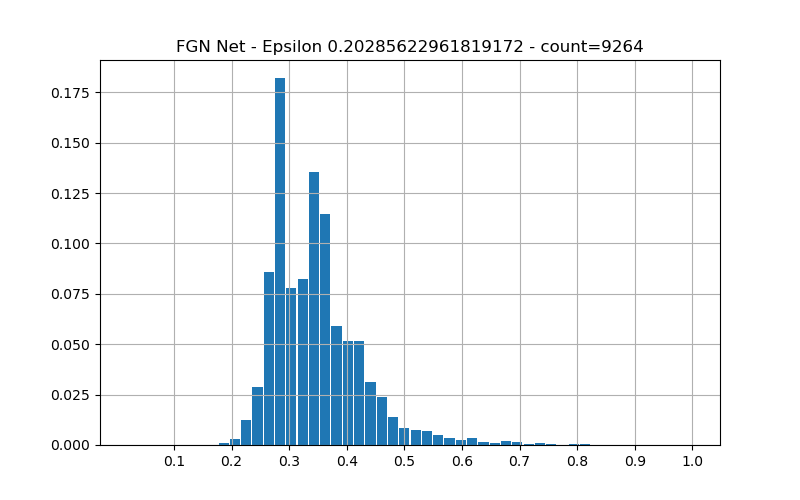

Statistical description of the predictions maximums
DescribeResult(nobs=9264, minmax=(0.17209405612128265032, 0.95902903689452078826), mean=0.3456918738575368398, variance=0.006160133254958896987, skewness=1.5367517416703542439, kurtosis=4.2968815055953921414)

percentage of confident predictions (>=0.5): 0.041882556131260795

Sample predictions
index 5136 prediction [0.   0.15 0.11 0.17 0.01 0.14 0.01 0.36 0.   0.03]
index 7042 prediction [0.02 0.06 0.12 0.24 0.01 0.11 0.01 0.12 0.23 0.08]
index 1745 prediction [0.01 0.04 0.08 0.24 0.01 0.15 0.01 0.06 0.33 0.07]
index 2251 prediction [0.01 0.04 0.08 0.25 0.01 0.16 0.01 0.06 0.32 0.07]
index 5561 prediction [0.01 0.04 0.07 0.28 0.01 0.22 0.01 0.06 0.24 0.06]


<IPython.core.display.Javascript object>


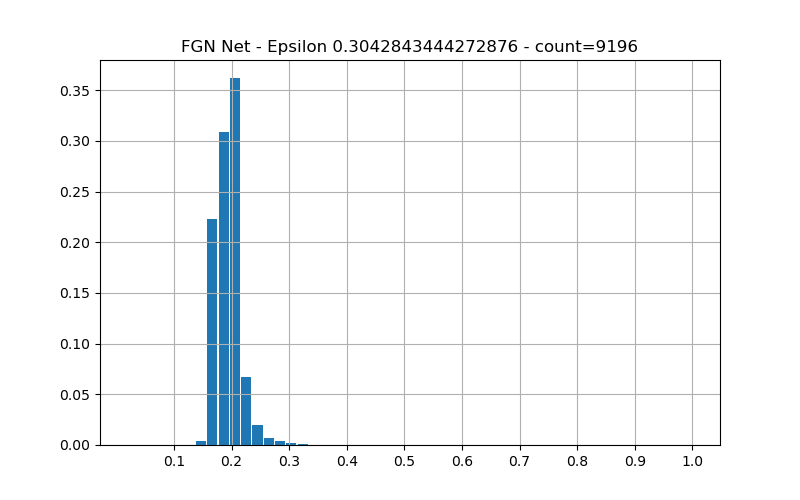

Statistical description of the predictions maximums
DescribeResult(nobs=9196, minmax=(0.14594510058843033854, 0.51617980665532825247), mean=0.19454059879635296026, variance=0.0004516646256479403653, skewness=2.0635314872186441575, kurtosis=14.1457341755176508585)

percentage of confident predictions (>=0.5): 0.00010874293170943889

Sample predictions
index 531 prediction [0.02 0.15 0.16 0.17 0.05 0.16 0.07 0.14 0.04 0.05]
index 4705 prediction [0.03 0.1  0.13 0.19 0.05 0.16 0.04 0.12 0.1  0.07]
index 7058 prediction [0.02 0.09 0.13 0.21 0.05 0.18 0.04 0.12 0.09 0.07]
index 7702 prediction [0.03 0.12 0.14 0.16 0.06 0.17 0.08 0.12 0.06 0.06]
index 667 prediction [0.02 0.1  0.13 0.2  0.05 0.18 0.04 0.12 0.09 0.07]


<IPython.core.display.Javascript object>


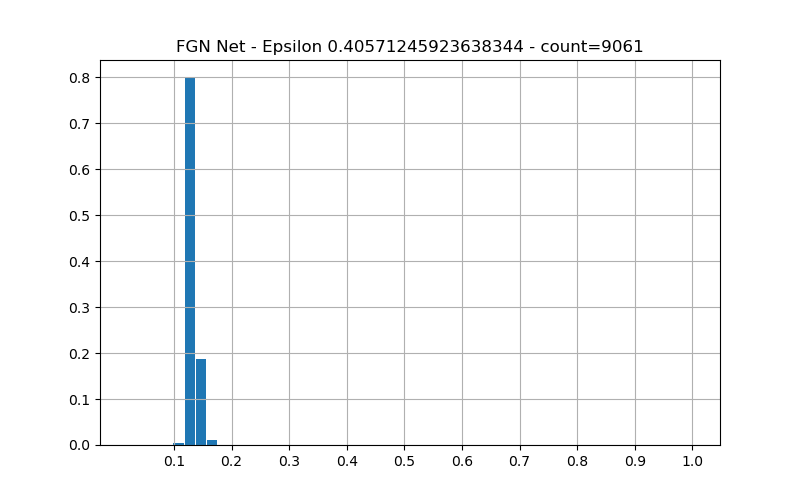

Statistical description of the predictions maximums
DescribeResult(nobs=9061, minmax=(0.11286516933915570254, 0.20465613261555541013), mean=0.1329857001327471047, variance=5.1285372567062729642e-05, skewness=1.6778578933702158135, kurtosis=6.6560389024547288797)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5365 prediction [0.06 0.11 0.12 0.13 0.09 0.12 0.1  0.09 0.1  0.08]
index 5377 prediction [0.05 0.12 0.12 0.13 0.08 0.13 0.1  0.1  0.1  0.08]
index 7205 prediction [0.05 0.11 0.12 0.13 0.09 0.13 0.09 0.1  0.1  0.08]
index 380 prediction [0.05 0.11 0.12 0.13 0.09 0.13 0.09 0.1  0.1  0.08]
index 5823 prediction [0.06 0.11 0.12 0.12 0.09 0.12 0.1  0.09 0.1  0.08]


<IPython.core.display.Javascript object>


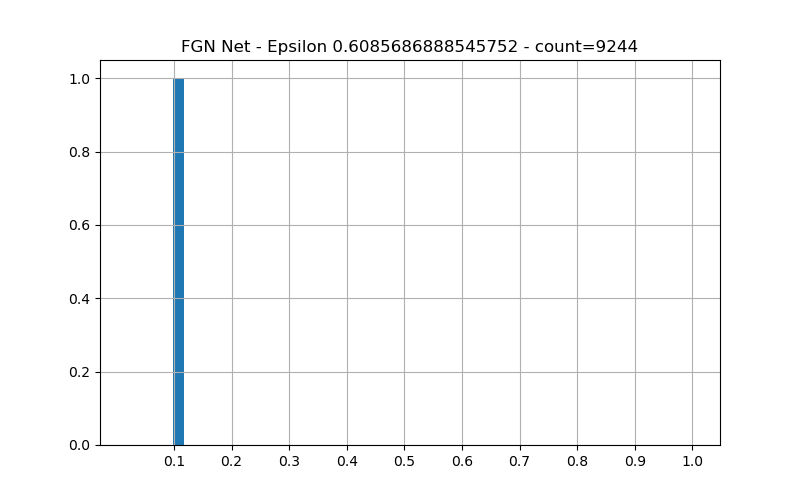

Statistical description of the predictions maximums
DescribeResult(nobs=9244, minmax=(0.1007136416215396046, 0.113444698210759912606), mean=0.10334069222188415367, variance=1.4615712953481566268e-06, skewness=2.1591513998753784403, kurtosis=7.9582340637882639485)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6174 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]
index 3925 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]
index 760 prediction [0.09 0.1  0.1  0.11 0.1  0.1  0.1  0.09 0.1  0.09]
index 1386 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3314 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]


<IPython.core.display.Javascript object>


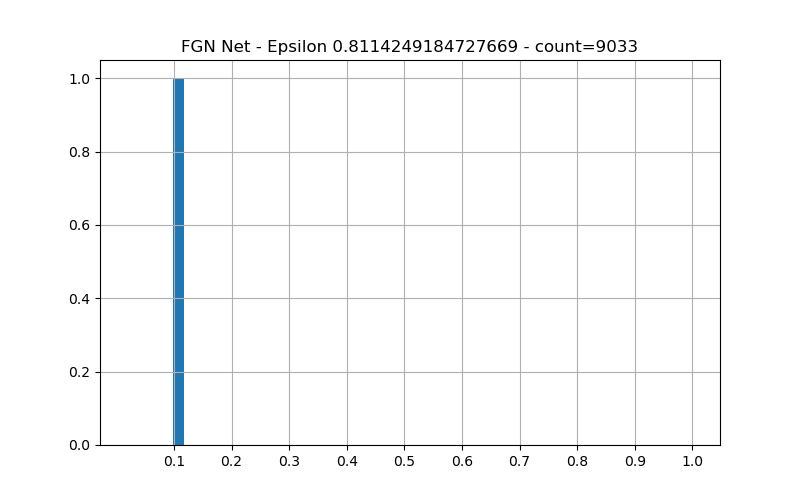

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10001333990253152947, 0.102154624681022550864), mean=0.100257986559537592076, variance=2.984595795821147553e-08, skewness=3.0573810218634938484, kurtosis=15.000797073519851678)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7753 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 399 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2665 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1134 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4232 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


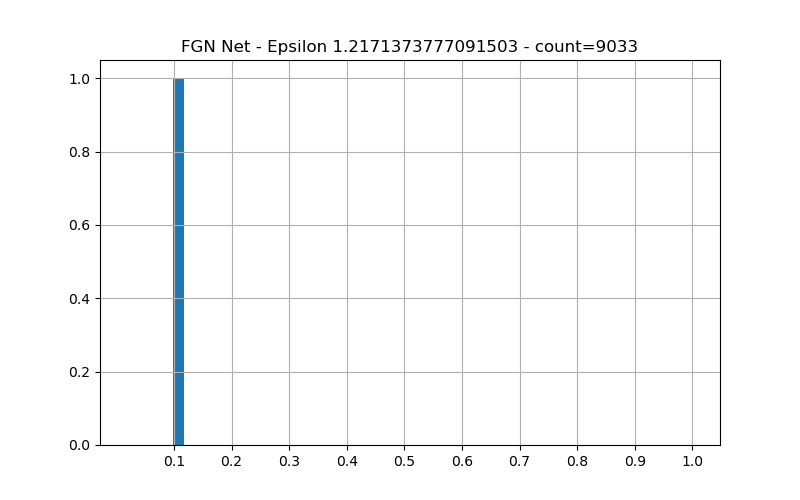

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.100000000141565020877, 0.10001648107466909025), mean=0.100000201245372651595, variance=3.1718677439772288168e-13, skewness=10.739186028450327931, kurtosis=176.95841765146863504)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8994 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2858 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7291 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3793 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8546 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


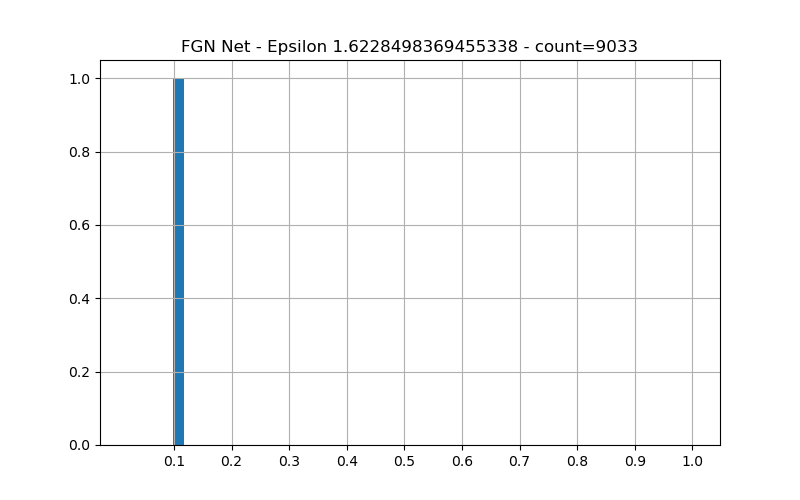

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000000000000001536, 0.10000001561391742083), mean=0.10000000002900045744, variance=8.0054730727785735663e-20, skewness=29.373650723126015754, kurtosis=1260.7130636062980005)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4278 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8819 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1829 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4072 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6240 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


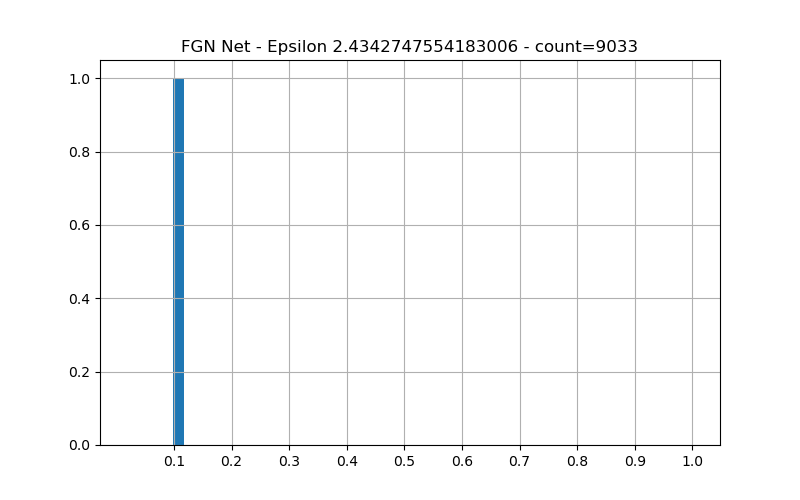

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.10000000000000003582), mean=0.10000000000000000002, variance=1.6561456996493194669e-37, skewness=78.45224356686568862, kurtosis=6710.411033673233365)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5930 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 9019 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2215 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4882 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2269 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


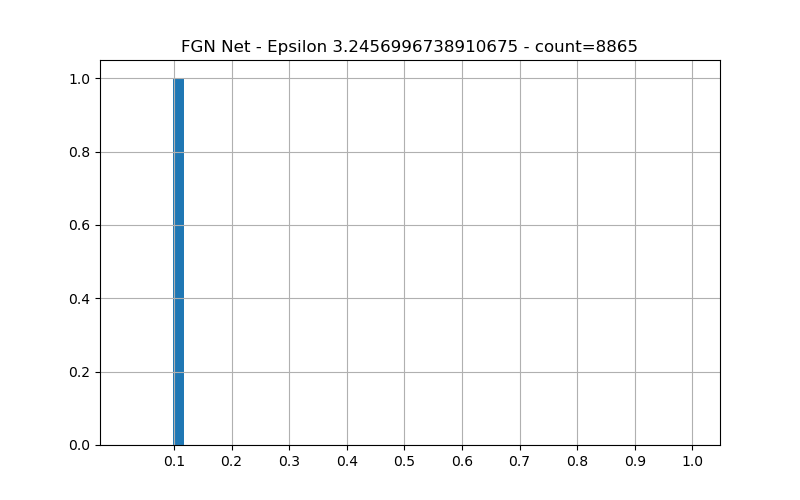

Statistical description of the predictions maximums
DescribeResult(nobs=8865, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.836917133214332334e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6216 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1573 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5645 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1873 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3662 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [38]:
# rerun the fgn model on adv examples
for i ,fgn_raw_images in enumerate(fgn_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(fgn_raw_images))
    t = 'FGN Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(fgn_model, dl, title=t, verbose=True)

<IPython.core.display.Javascript object>


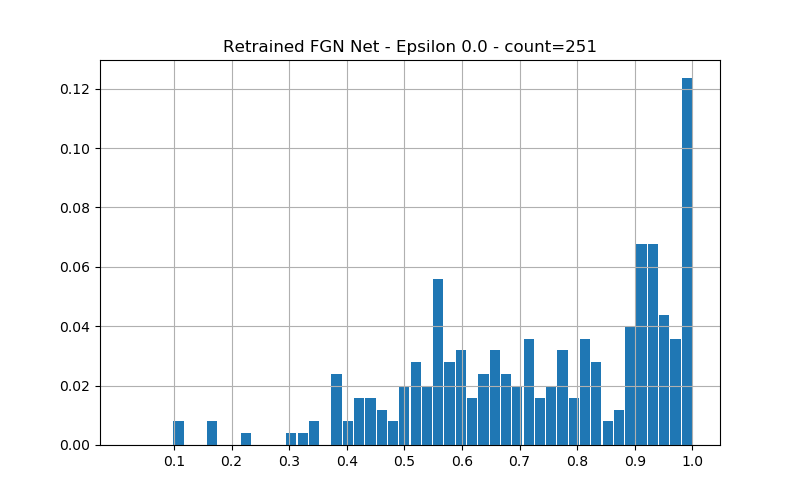

Statistical description of the predictions maximums
DescribeResult(nobs=251, minmax=(0.10698620681844382571, 0.99963852086341862835), mean=0.73989801278233461234, variance=0.04360106048699284783, skewness=-0.5906437491298743233, kurtosis=-0.41283159267936933275)

percentage of confident predictions (>=0.5): 0.8685258964143426

Sample predictions
index 107 prediction [0.   0.   0.   0.77 0.   0.23 0.   0.   0.   0.  ]
index 95 prediction [0.   0.   0.   0.   0.   0.17 0.53 0.   0.3  0.  ]
index 12 prediction [0.   0.   0.   0.   0.99 0.   0.   0.01 0.   0.01]
index 97 prediction [0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
index 89 prediction [0.49 0.   0.32 0.   0.01 0.04 0.05 0.02 0.07 0.01]


<IPython.core.display.Javascript object>


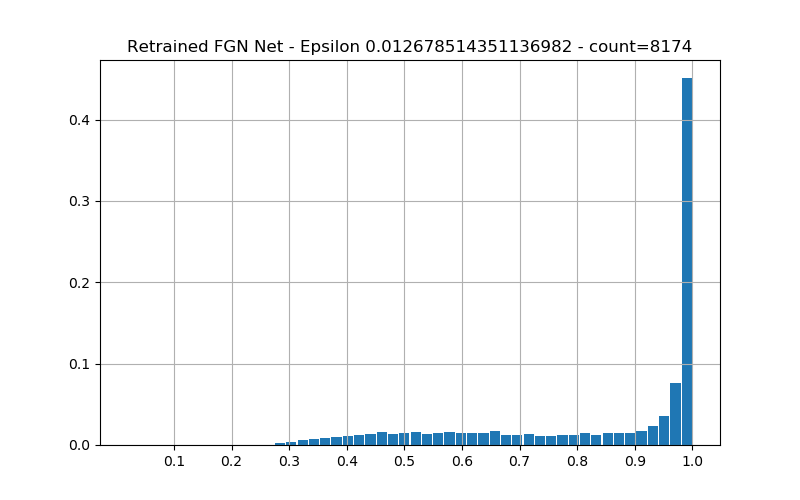

Statistical description of the predictions maximums
DescribeResult(nobs=8174, minmax=(0.107149800262439019545, 0.9990979638061662677), mean=0.83698381220035769314, variance=0.043877740514655232096, skewness=-1.0632645627333267497, kurtosis=-0.29631464028085510742)

percentage of confident predictions (>=0.5): 0.8863469537558111

Sample predictions
index 3936 prediction [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
index 5937 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 5169 prediction [0.   0.   0.   0.01 0.   0.   0.   0.   0.98 0.  ]
index 2206 prediction [0.35 0.   0.02 0.   0.   0.01 0.02 0.   0.59 0.  ]
index 7918 prediction [0.   0.08 0.   0.04 0.   0.   0.   0.   0.86 0.02]


<IPython.core.display.Javascript object>


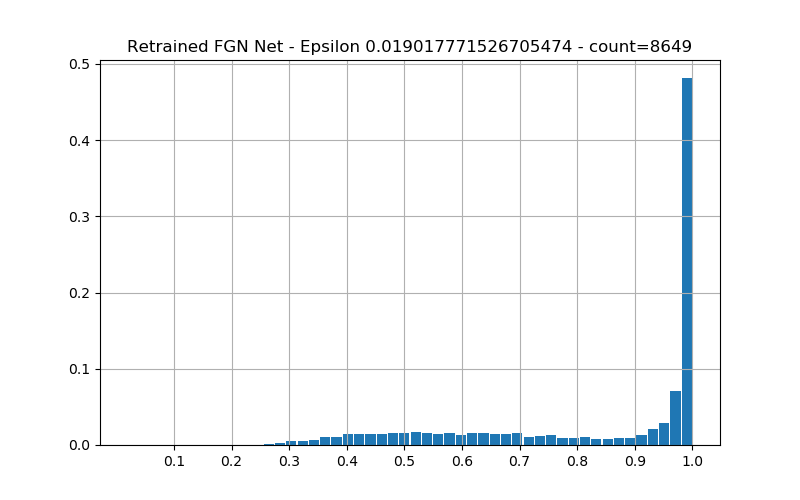

Statistical description of the predictions maximums
DescribeResult(nobs=8649, minmax=(0.107131119956011718934, 0.9990495177225839135), mean=0.832368746337901802, variance=0.04703075515007248983, skewness=-1.0173438628982094891, kurtosis=-0.45140454146667310128)

percentage of confident predictions (>=0.5): 0.8729332870852121

Sample predictions
index 6781 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 2814 prediction [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
index 3608 prediction [0.   0.03 0.9  0.01 0.   0.   0.01 0.04 0.   0.  ]
index 6991 prediction [0.   0.   0.   0.   0.   0.01 0.   0.   0.99 0.  ]
index 5941 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]


<IPython.core.display.Javascript object>


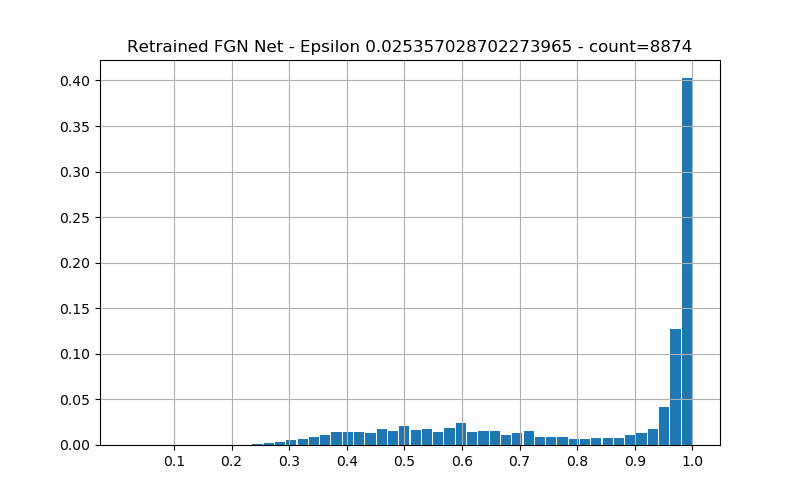

Statistical description of the predictions maximums
DescribeResult(nobs=8874, minmax=(0.10696734675393540389, 0.9991591203557297194), mean=0.8191101870667160185, variance=0.049247029043587780987, skewness=-0.9243827948989365742, kurtosis=-0.67071815895352350327)

percentage of confident predictions (>=0.5): 0.8612801442416047

Sample predictions
index 2295 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.01]
index 6378 prediction [0.   0.   0.01 0.03 0.   0.   0.   0.78 0.   0.17]
index 4336 prediction [0.   0.   0.   0.   0.   0.   0.   0.   0.99 0.  ]
index 5842 prediction [0.   0.01 0.   0.01 0.   0.   0.   0.   0.97 0.01]
index 3851 prediction [0.   0.11 0.06 0.13 0.   0.63 0.   0.08 0.   0.  ]


<IPython.core.display.Javascript object>


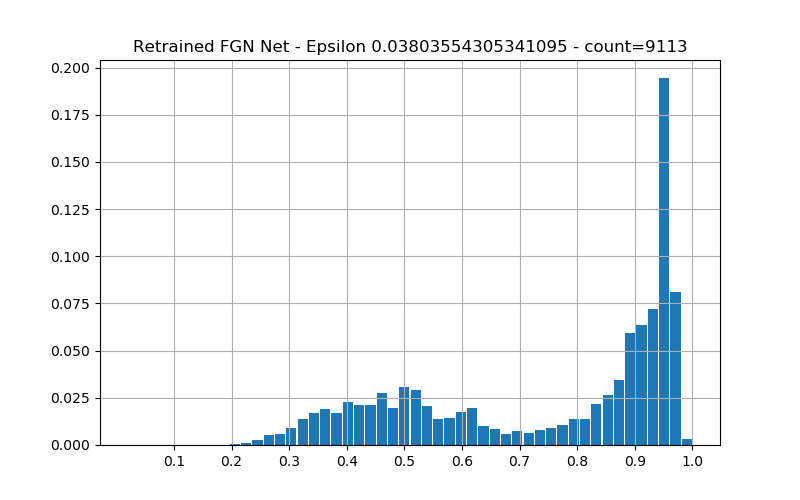

Statistical description of the predictions maximums
DescribeResult(nobs=9113, minmax=(0.10659100949333501562, 0.9962673739330868489), mean=0.74526136826635081196, variance=0.051641060890933891186, skewness=-0.62697467238114414615, kurtosis=-1.1749922682344395985)

percentage of confident predictions (>=0.5): 0.7815209042027872

Sample predictions
index 1365 prediction [0.   0.08 0.07 0.1  0.   0.11 0.   0.62 0.   0.02]
index 6557 prediction [0.   0.   0.   0.01 0.   0.01 0.   0.   0.97 0.01]
index 4873 prediction [0.   0.1  0.24 0.12 0.   0.37 0.03 0.14 0.   0.  ]
index 1693 prediction [0.   0.14 0.05 0.17 0.   0.3  0.   0.33 0.   0.01]
index 2209 prediction [0.   0.   0.01 0.02 0.   0.01 0.   0.   0.94 0.01]


<IPython.core.display.Javascript object>


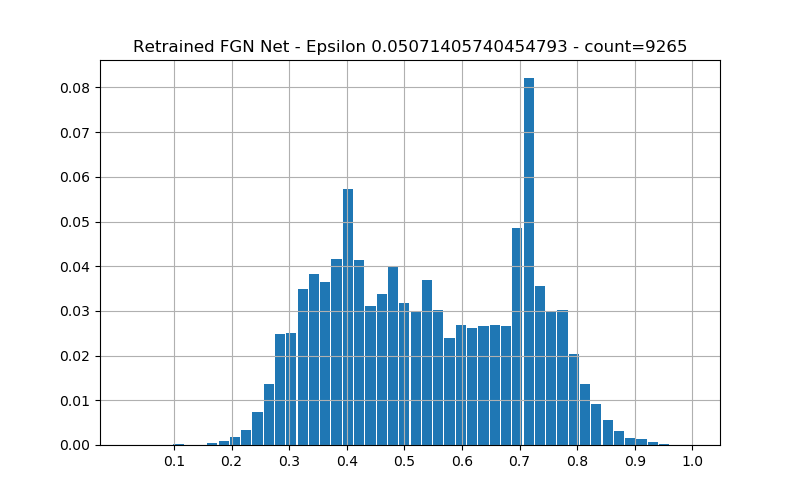

Statistical description of the predictions maximums
DescribeResult(nobs=9265, minmax=(0.10601564109609586846, 0.943992306252780983), mean=0.54123367438896424834, variance=0.027194616667228514147, skewness=0.04208123718235920359, kurtosis=-1.1645090573362381568)

percentage of confident predictions (>=0.5): 0.5500269832703724

Sample predictions
index 3177 prediction [0.06 0.01 0.09 0.25 0.02 0.15 0.02 0.02 0.33 0.03]
index 854 prediction [0.   0.02 0.04 0.18 0.01 0.14 0.   0.02 0.55 0.04]
index 1352 prediction [0.   0.01 0.02 0.1  0.   0.06 0.   0.01 0.75 0.04]
index 7592 prediction [0.   0.01 0.02 0.07 0.   0.04 0.   0.01 0.82 0.02]
index 6945 prediction [0.   0.02 0.03 0.07 0.   0.04 0.   0.01 0.79 0.03]


<IPython.core.display.Javascript object>


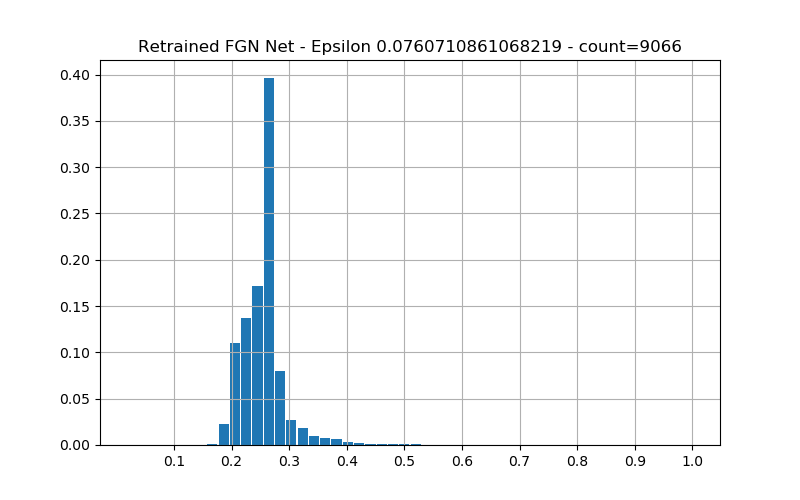

Statistical description of the predictions maximums
DescribeResult(nobs=9066, minmax=(0.104182737290898998865, 0.68228067269552860707), mean=0.2553720153287528982, variance=0.001547408218069440511, skewness=2.1741356423335065245, kurtosis=12.1862091733834290615)

percentage of confident predictions (>=0.5): 0.001985440105890139

Sample predictions
index 371 prediction [0.01 0.14 0.09 0.19 0.03 0.1  0.01 0.28 0.04 0.11]
index 3862 prediction [0.01 0.13 0.12 0.21 0.02 0.23 0.03 0.19 0.01 0.04]
index 6963 prediction [0.01 0.08 0.1  0.32 0.03 0.11 0.01 0.08 0.17 0.1 ]
index 4630 prediction [0.01 0.12 0.15 0.19 0.03 0.19 0.03 0.22 0.01 0.04]
index 2679 prediction [0.01 0.06 0.12 0.27 0.02 0.17 0.02 0.09 0.17 0.07]


<IPython.core.display.Javascript object>


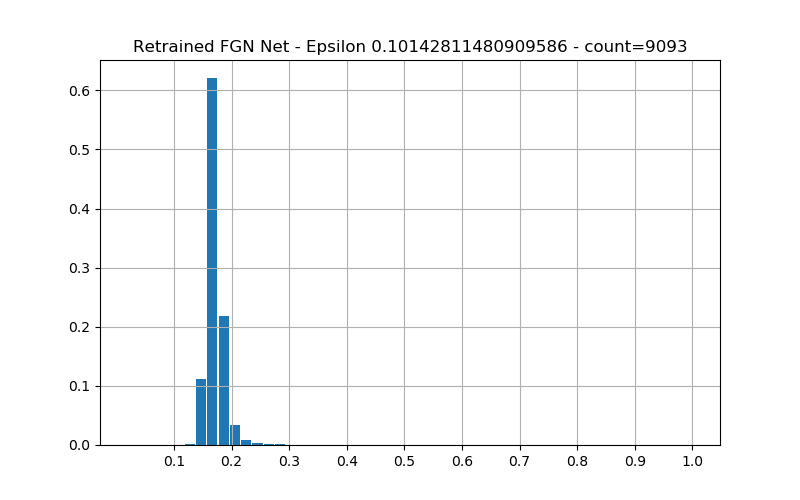

Statistical description of the predictions maximums
DescribeResult(nobs=9093, minmax=(0.10231912991997382949, 0.36591603974397534407), mean=0.17111149696670332863, variance=0.00021870603166407354551, skewness=2.1452654487055740065, kurtosis=13.426143462420779993)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 382 prediction [0.02 0.12 0.14 0.17 0.06 0.17 0.07 0.14 0.05 0.06]
index 2287 prediction [0.03 0.11 0.14 0.18 0.06 0.15 0.05 0.12 0.09 0.07]
index 973 prediction [0.03 0.13 0.13 0.16 0.07 0.15 0.07 0.12 0.06 0.07]
index 1268 prediction [0.04 0.11 0.12 0.15 0.08 0.15 0.09 0.1  0.09 0.07]
index 5330 prediction [0.03 0.13 0.14 0.16 0.07 0.15 0.09 0.11 0.07 0.06]


<IPython.core.display.Javascript object>


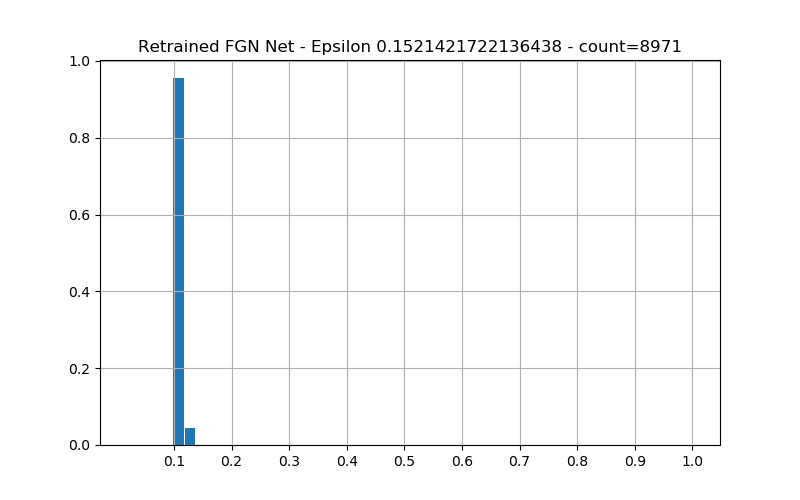

Statistical description of the predictions maximums
DescribeResult(nobs=8971, minmax=(0.10050957236255120276, 0.1411709379277200299), mean=0.11145691057127961843, variance=1.0616738289622044785e-05, skewness=1.9339532747115990778, kurtosis=8.052637966649894914)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3123 prediction [0.07 0.11 0.11 0.11 0.1  0.11 0.11 0.09 0.1  0.09]
index 425 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.1  0.09]
index 1394 prediction [0.07 0.11 0.11 0.11 0.1  0.11 0.11 0.09 0.11 0.09]
index 3513 prediction [0.08 0.1  0.11 0.11 0.1  0.11 0.11 0.09 0.1  0.09]
index 702 prediction [0.07 0.11 0.11 0.11 0.1  0.11 0.11 0.09 0.11 0.09]


<IPython.core.display.Javascript object>


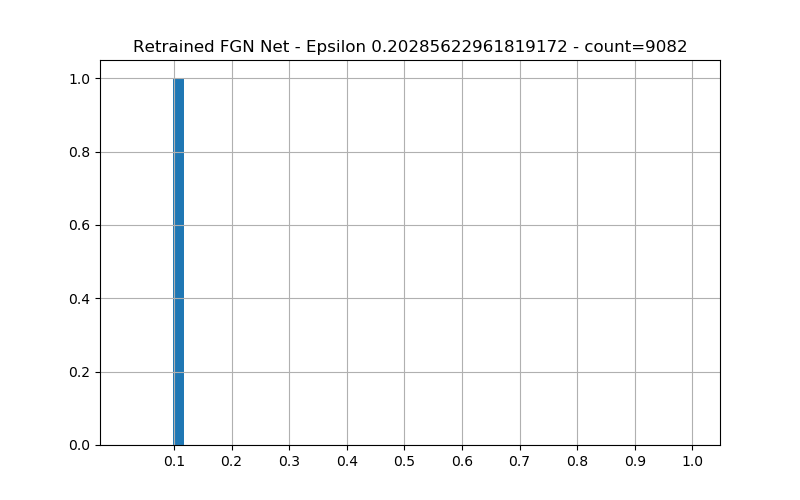

Statistical description of the predictions maximums
DescribeResult(nobs=9082, minmax=(0.100058274637173135413, 0.10827323904862675221), mean=0.10165379153259226786, variance=4.8749186997073729843e-07, skewness=2.6539351632337500957, kurtosis=13.764354095648304477)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 1923 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]
index 6669 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8840 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]
index 4179 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1871 prediction [0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1 ]


<IPython.core.display.Javascript object>


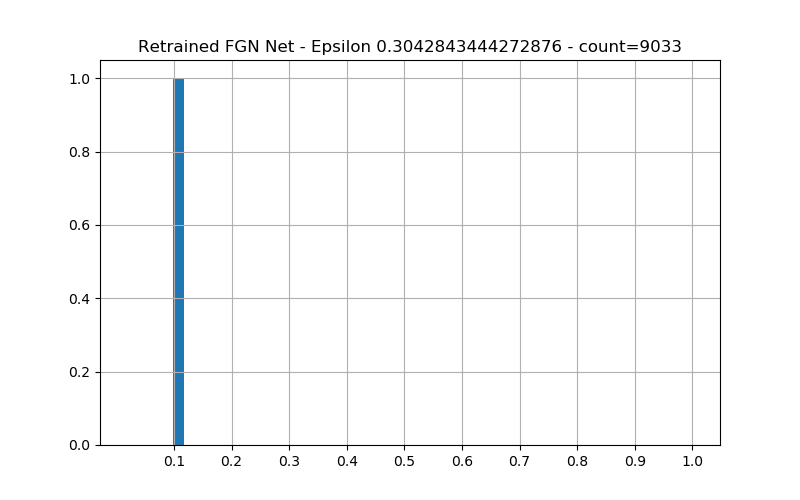

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.10000012876035107547, 0.10030472175663081672), mean=0.10001111798070980042, variance=2.5513404734199786086e-10, skewness=7.4992050875883053147, kurtosis=90.37053344933689187)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 726 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7227 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8816 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2514 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4905 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


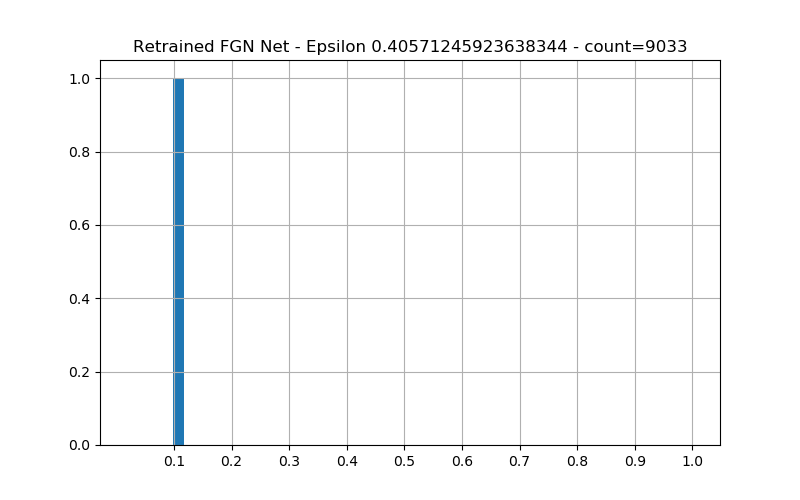

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.100000000003562808246, 0.100002891225186154775), mean=0.1000000168024387532, variance=8.316437380458785346e-15, skewness=19.306479463588795136, kurtosis=472.82277807223913452)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2714 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1388 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8096 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7172 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2669 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


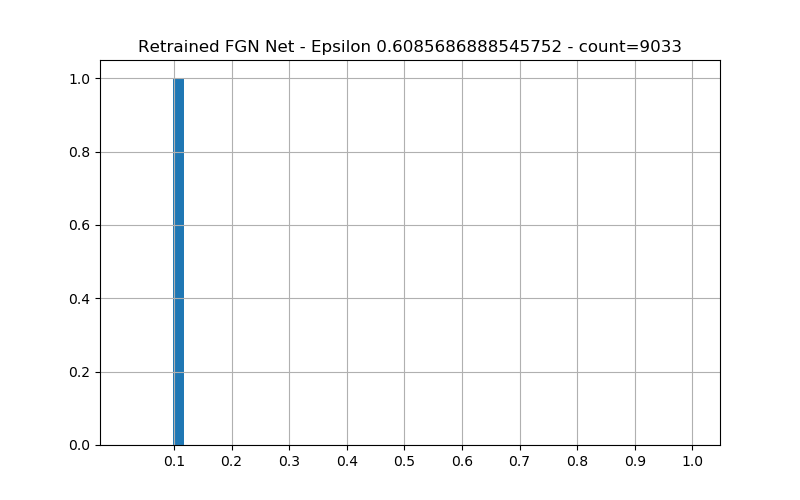

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.1000000000046389945), mean=0.100000000000003979233, variance=9.3631671643954966194e-27, skewness=35.283131543428525725, kurtosis=1363.0012382345002451)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2641 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2733 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2450 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8961 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7176 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


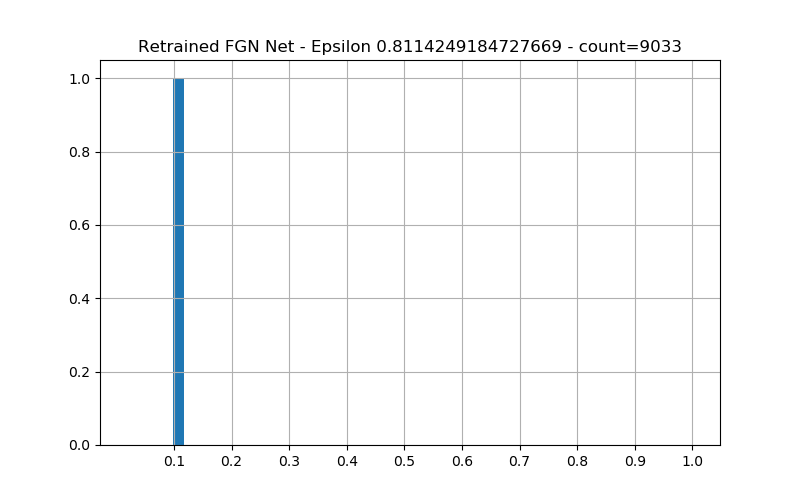

Statistical description of the predictions maximums
DescribeResult(nobs=9033, minmax=(0.1, 0.100000000000000000035), mean=0.100000000000000000015, variance=1.8362523725257332652e-40, skewness=-0.999390744118466199, kurtosis=-1.9994531291157215203)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 534 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1157 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 369 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6244 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8903 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


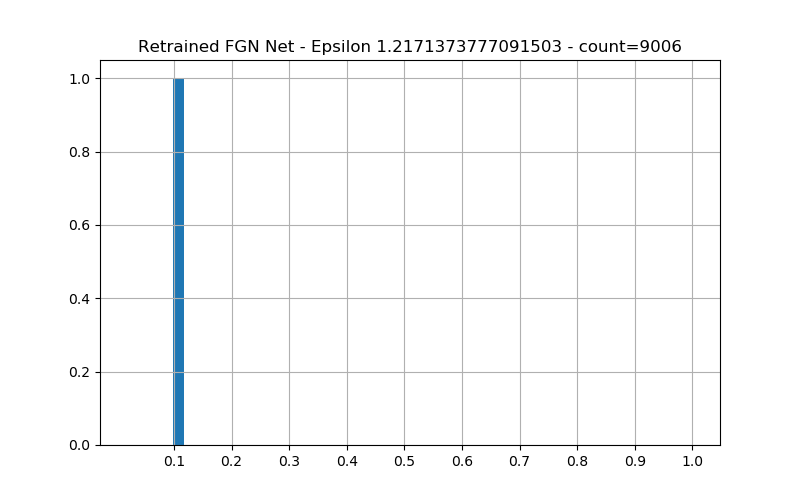

Statistical description of the predictions maximums
DescribeResult(nobs=9006, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138887259719074e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2872 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6075 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1567 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5440 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3917 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


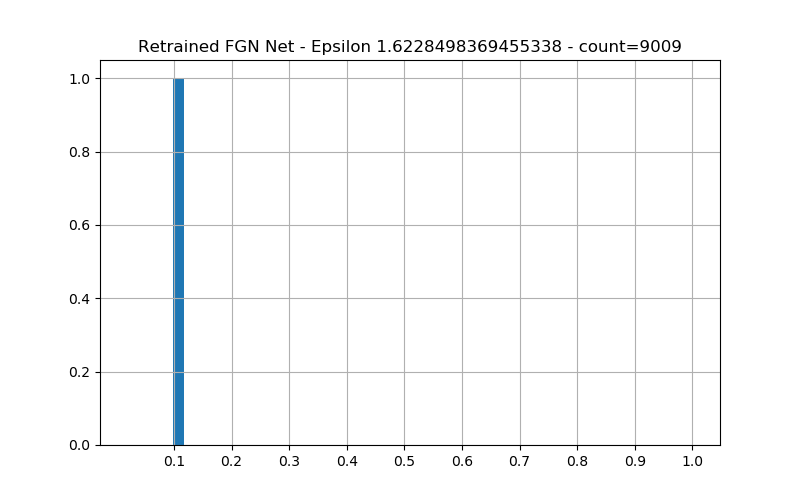

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 4101 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7360 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4236 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3115 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7808 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


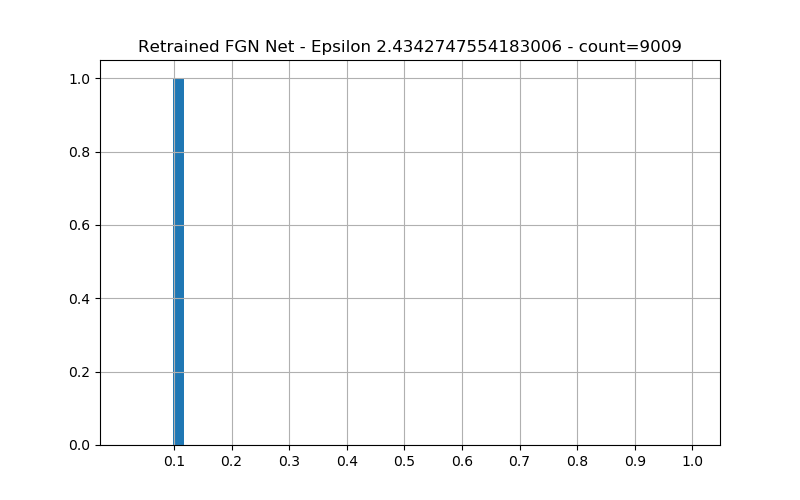

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3615 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3940 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7630 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 252 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5668 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


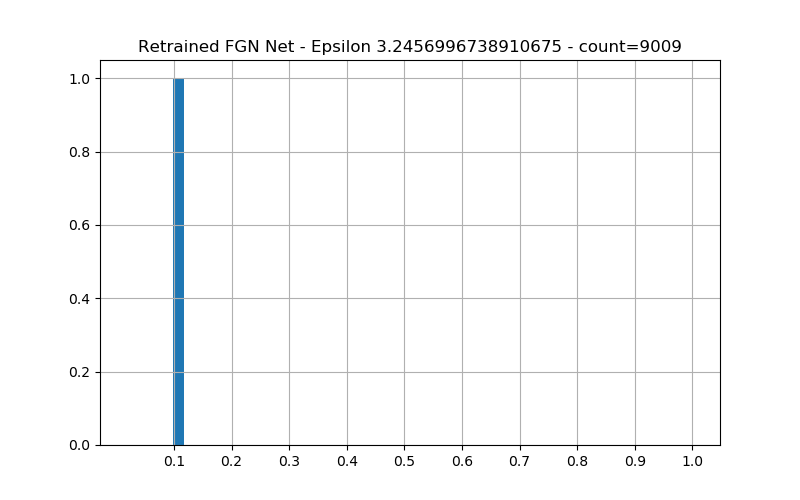

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5942 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6241 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1963 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5652 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8457 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [39]:
# rerun the ret_quick_fgn model on adv examples
for i, ret_quick_fgn_raw_images in enumerate(ret_quick_fgn_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(ret_quick_fgn_raw_images))
    t = 'Retrained FGN Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(ret_quick_fgn_model, dl, title=t, verbose=True)

<IPython.core.display.Javascript object>


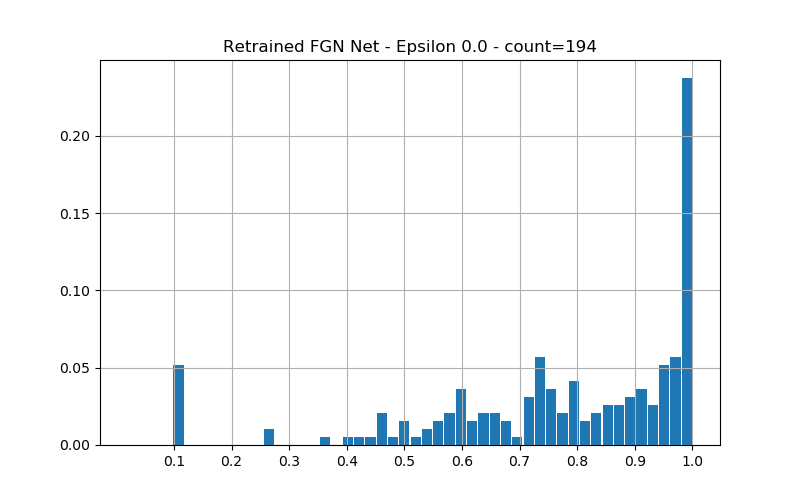

Statistical description of the predictions maximums
DescribeResult(nobs=194, minmax=(0.1, 0.9999922281204398924), mean=0.7756328360533916591, variance=0.055609447612774578513, skewness=-1.2943543267528453163, kurtosis=1.2789858591024869383)

percentage of confident predictions (>=0.5): 0.8865979381443299

Sample predictions
index 100 prediction [0.   0.   0.8  0.11 0.   0.   0.   0.07 0.   0.  ]
index 179 prediction [0.   0.91 0.01 0.04 0.   0.   0.   0.   0.03 0.  ]
index 116 prediction [0.   0.   0.   0.   0.98 0.   0.   0.01 0.   0.01]
index 104 prediction [0.   0.96 0.   0.02 0.   0.   0.   0.01 0.   0.  ]
index 94 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


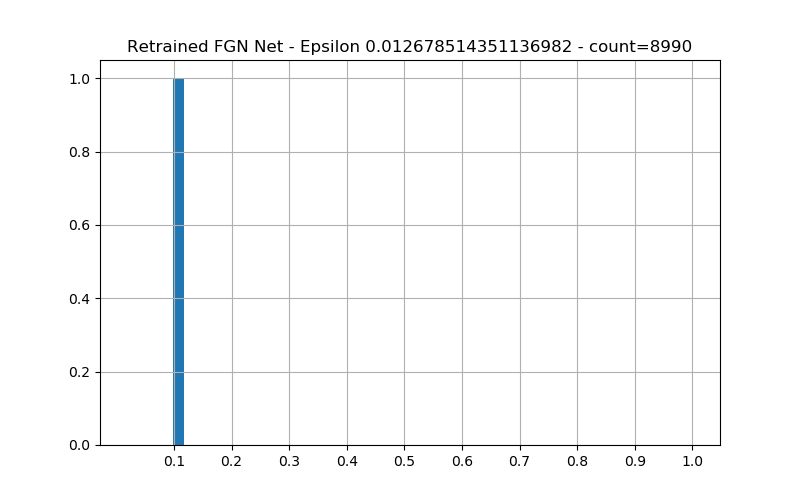

Statistical description of the predictions maximums
DescribeResult(nobs=8990, minmax=(0.1, 0.10000000000000024761), mean=0.10000000000000000026, variance=1.9466792585346228483e-35, skewness=36.328492942539367064, kurtosis=1650.1814453320604813)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 1995 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2406 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 271 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1167 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7286 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


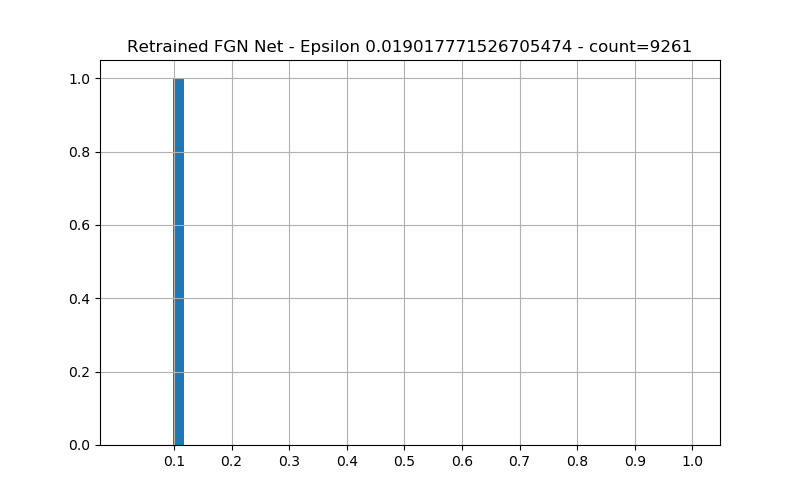

Statistical description of the predictions maximums
DescribeResult(nobs=9261, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369082719636211884e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 548 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2519 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1760 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6313 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8177 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


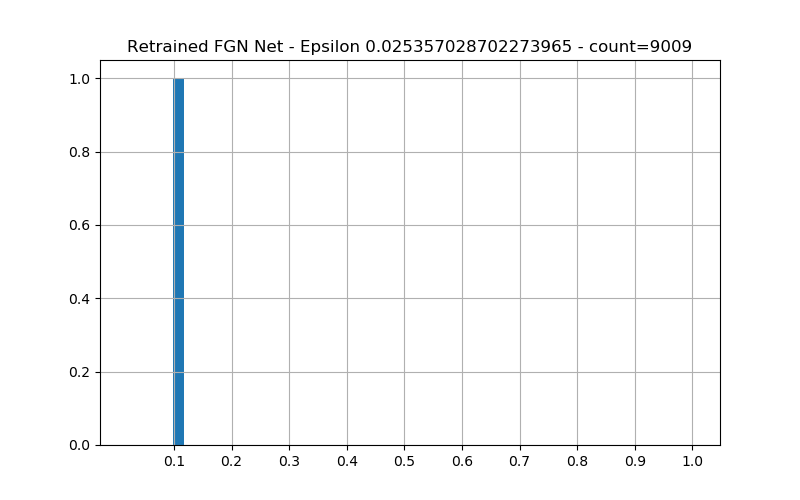

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 1291 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2822 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6894 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3300 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3521 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


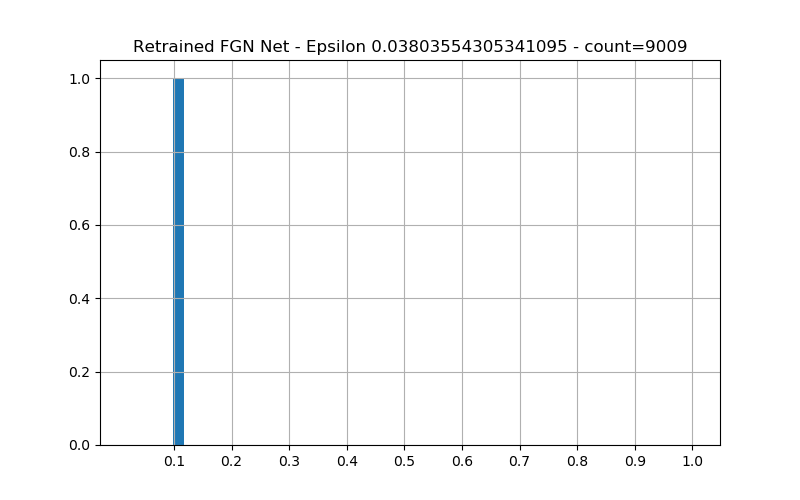

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6443 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8171 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2025 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 475 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2086 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


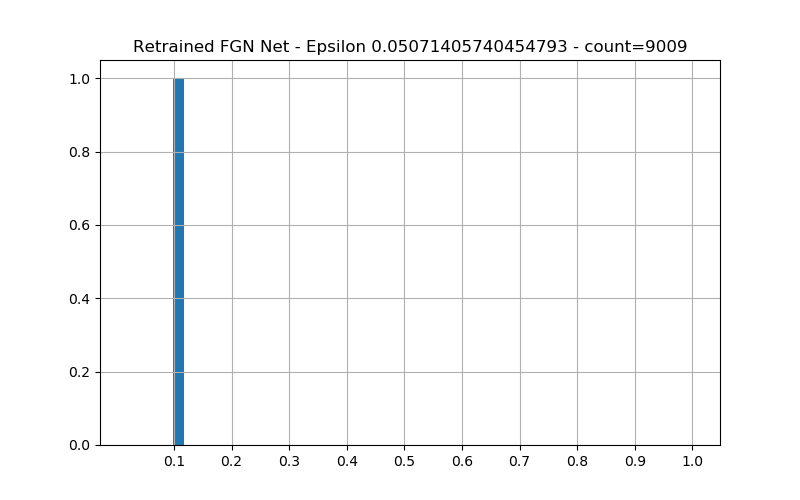

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7342 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6120 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1066 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5467 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1345 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


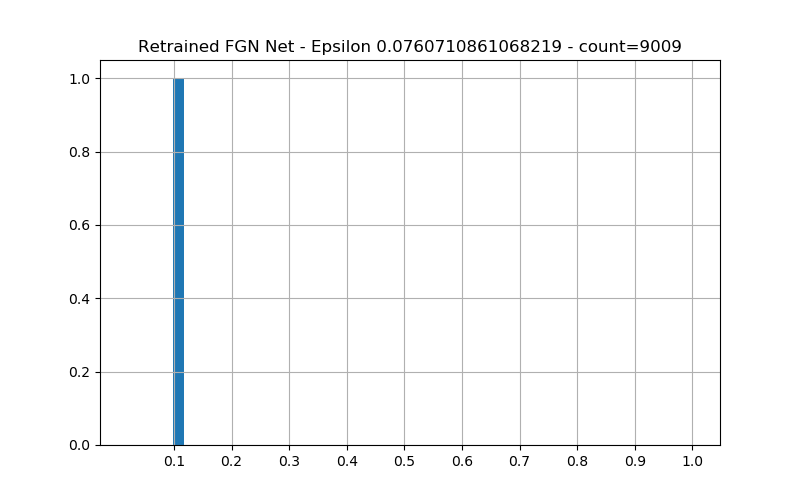

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3864 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7112 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7495 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2528 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3754 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


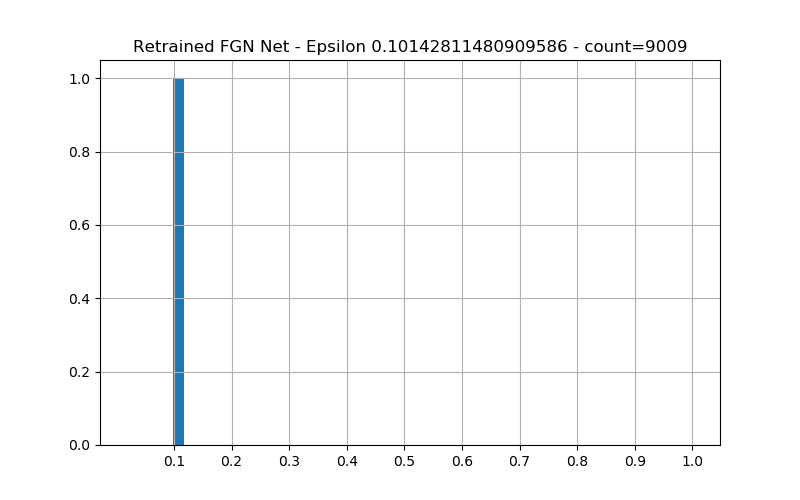

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 7917 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6792 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4763 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4684 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6228 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


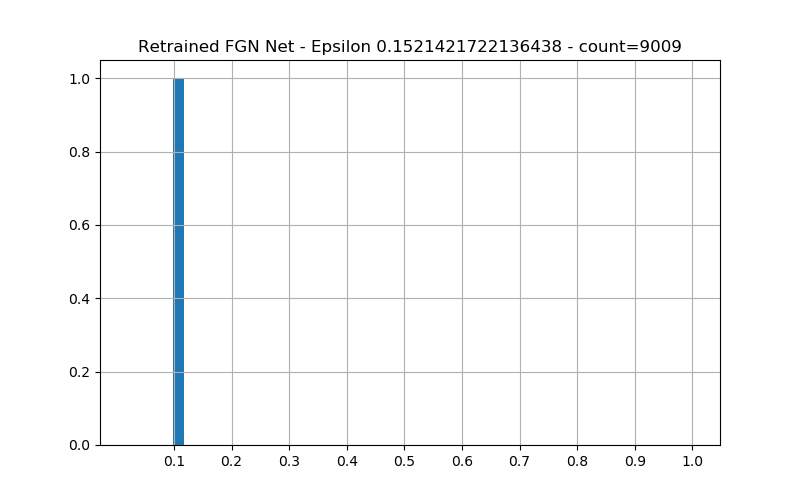

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 2263 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5562 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6450 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4210 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 489 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


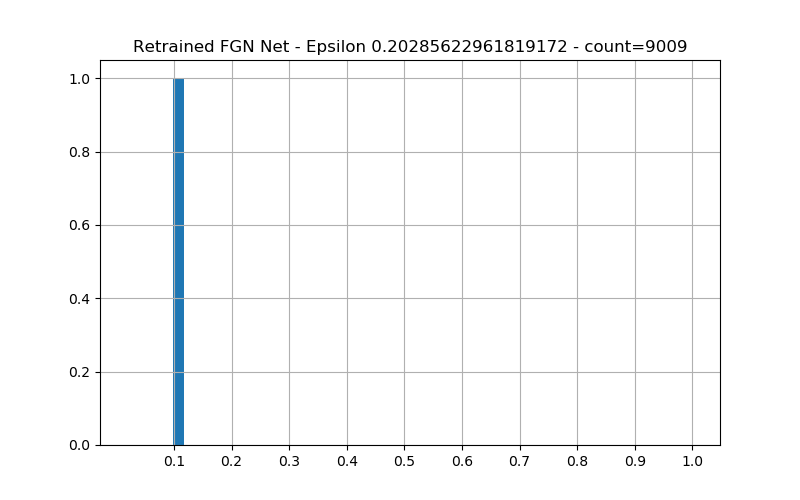

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 3404 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4583 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5470 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6775 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2065 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


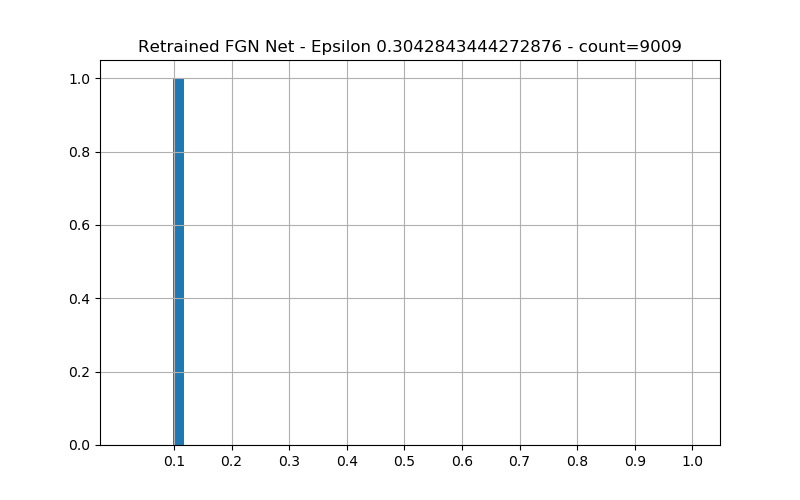

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 5742 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 951 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4258 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2880 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6012 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


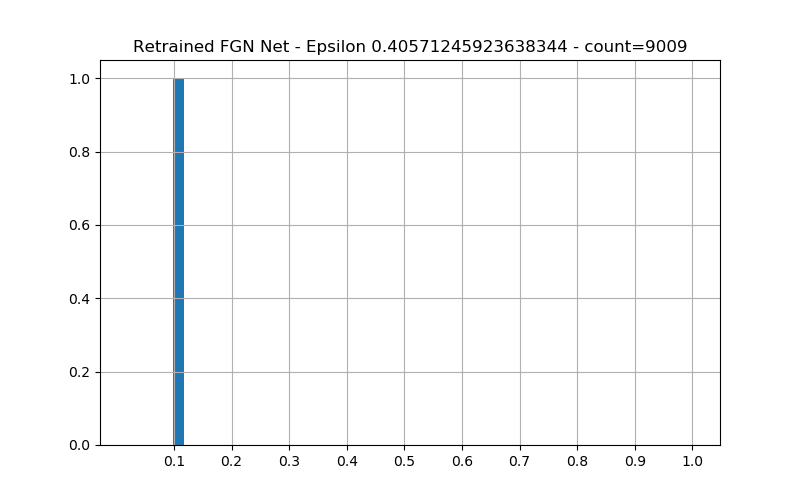

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 224 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 960 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4501 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4021 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6391 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


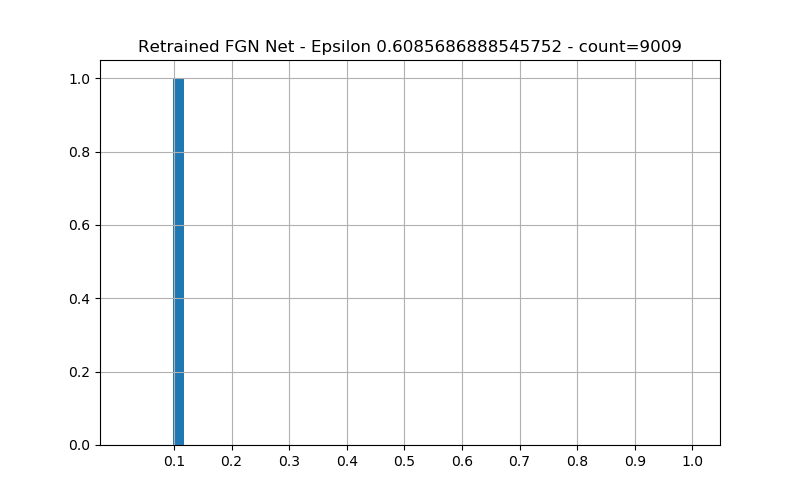

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8557 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2791 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7088 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4689 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3184 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


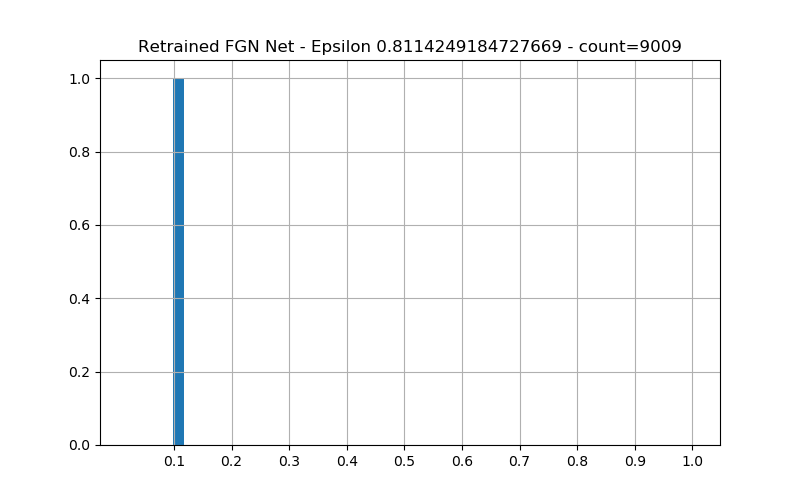

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6519 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2621 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7990 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5816 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2697 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


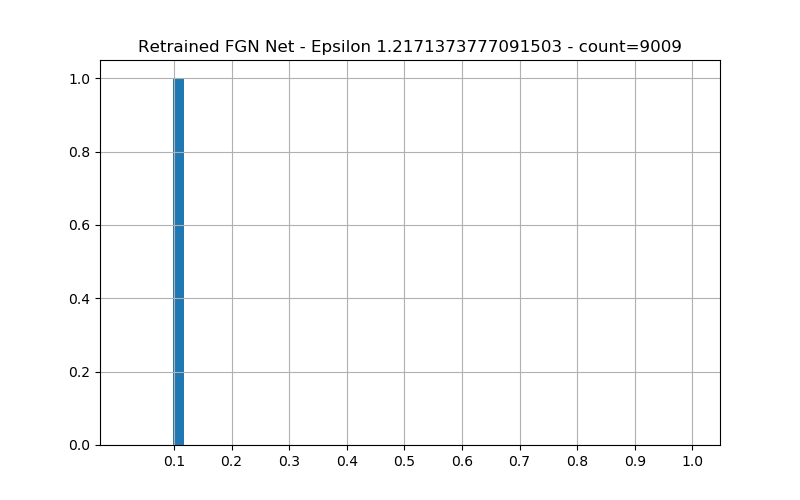

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 6354 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6440 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2241 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4933 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4880 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


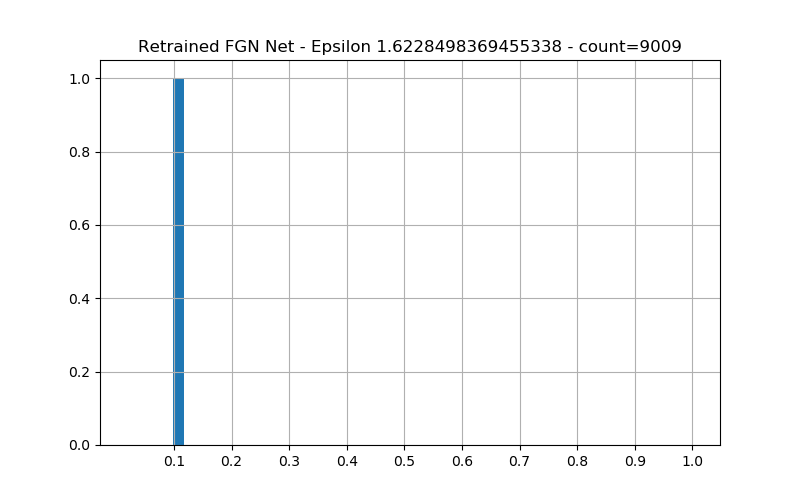

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 1038 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8133 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5428 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 6222 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 3 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


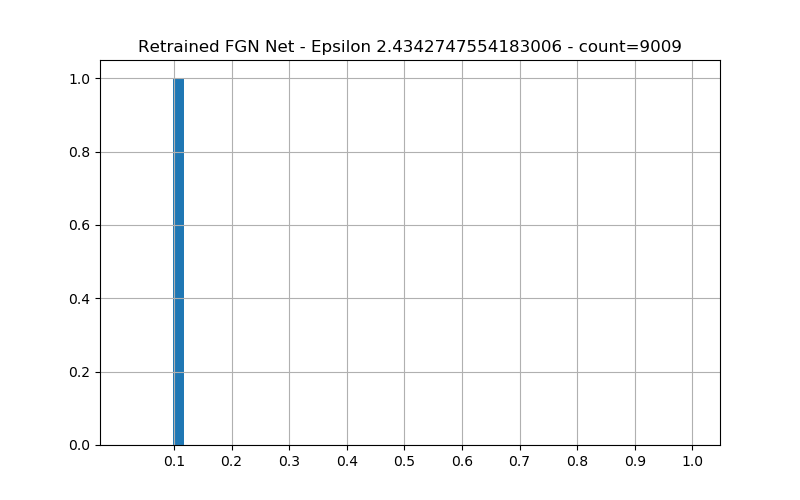

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8571 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 2688 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 8991 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 1452 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5427 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


<IPython.core.display.Javascript object>


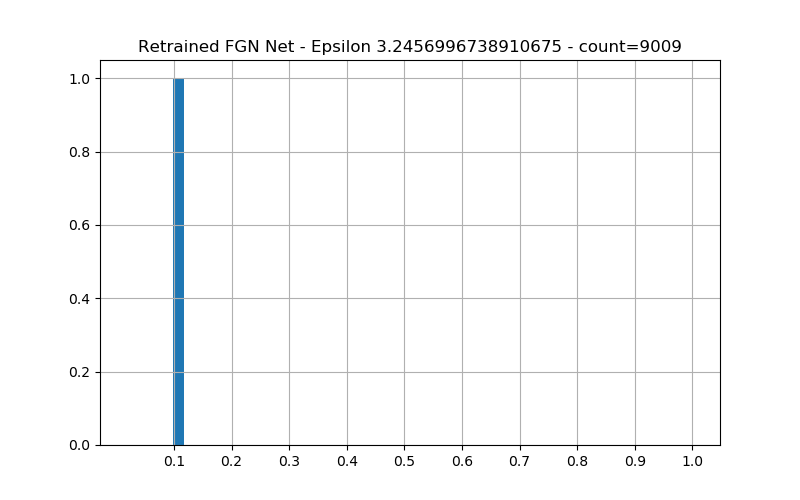

Statistical description of the predictions maximums
DescribeResult(nobs=9009, minmax=(0.1, 0.1), mean=0.100000000000000000015, variance=1.8369138207978304283e-40, skewness=-1.0, kurtosis=-2.0)

percentage of confident predictions (>=0.5): 0.0

Sample predictions
index 8569 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 7598 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 4020 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 5673 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
index 693 prediction [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [40]:
# rerun the ret_fgn model on adv examples
for i, ret_fgn_raw_images in enumerate(ret_fgn_raw_successful):
    # turn to dataloader
    dl =  torch.utils.data.DataLoader(torch.utils.data.TensorDataset(ret_fgn_raw_images))
    t = 'Retrained FGN Net - Epsilon {} - count={}'.format(epsilons[i], len(dl))
    fgnh.plot_pred_histogram(ret_fgn_model, dl, title=t, verbose=True)

In [41]:
ret_fgn_f_model(ret_fgn_raw[1][0])

tensor([[1.5606e-19, 9.8708e-20, 2.1181e-19, 1.1580e-19, 1.2427e-19, 1.0054e-19,
         2.3288e-19, 5.5054e-20, 3.1695e-19, 9.6273e-20]], device='cuda:1')

In [42]:
labels[0]

tensor(3, device='cuda:1')

In [43]:
ret_fgn_adv_success[1][0]

tensor(True, device='cuda:1')

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


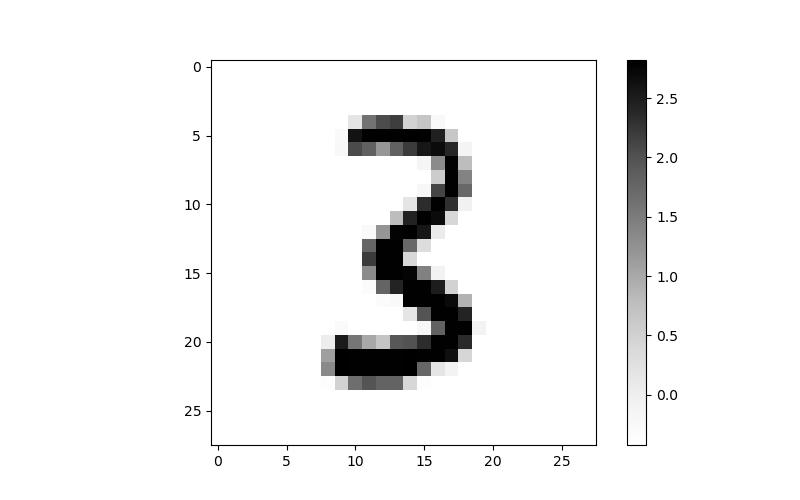

In [44]:
# original image
plt.imshow(images[0].cpu().numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.colorbar()
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


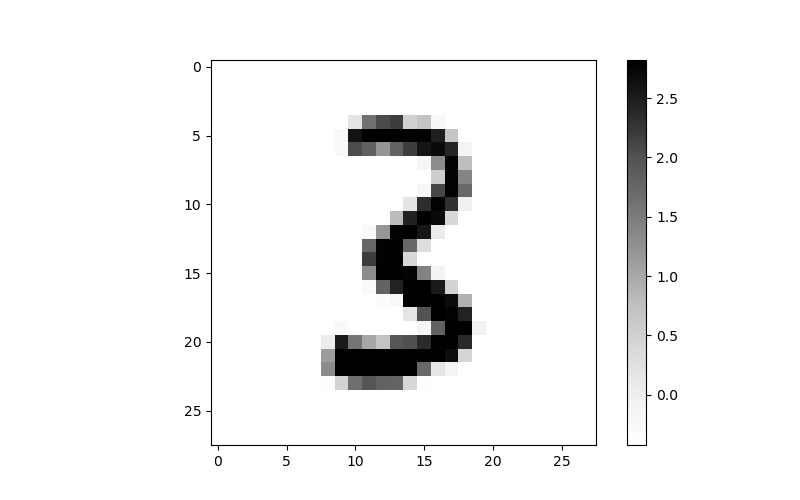

In [45]:
# adversarial image
plt.imshow(ret_fgn_raw[1][0].cpu().numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.colorbar()
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


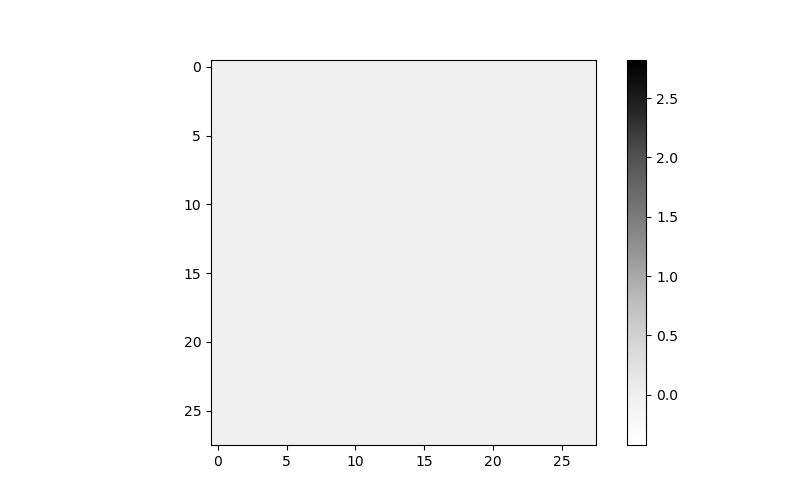

In [46]:
# noise
plt.imshow(images[0].cpu().numpy()-ret_fgn_raw[0][0].cpu().numpy(), vmin=min_pix, vmax=max_pix, cmap='Greys')
plt.colorbar()
plt.show()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


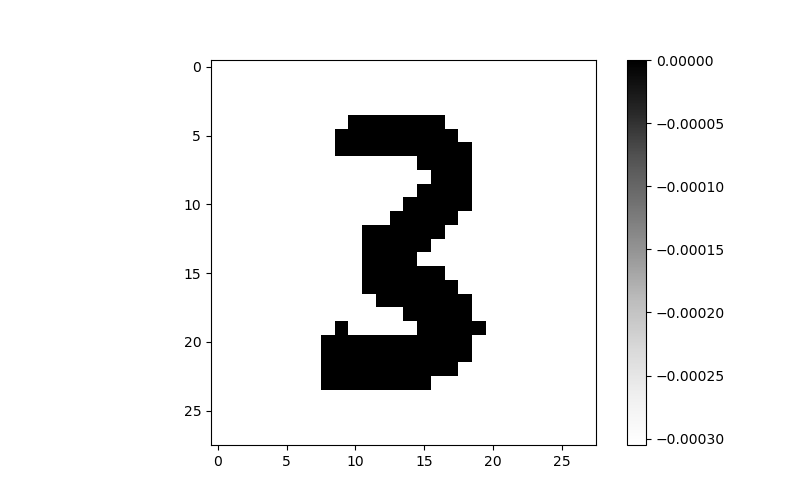

In [47]:
# noise with exagerated contrast
plt.imshow(images[0].cpu().numpy()-ret_fgn_raw[0][0].cpu().numpy(), cmap='Greys')
plt.colorbar()
plt.show()

In [48]:
# compare prediction confidences 

In [49]:
names = ['classic', 'fgn', 'retrained']
al = ['right', 'mid', 'left']

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


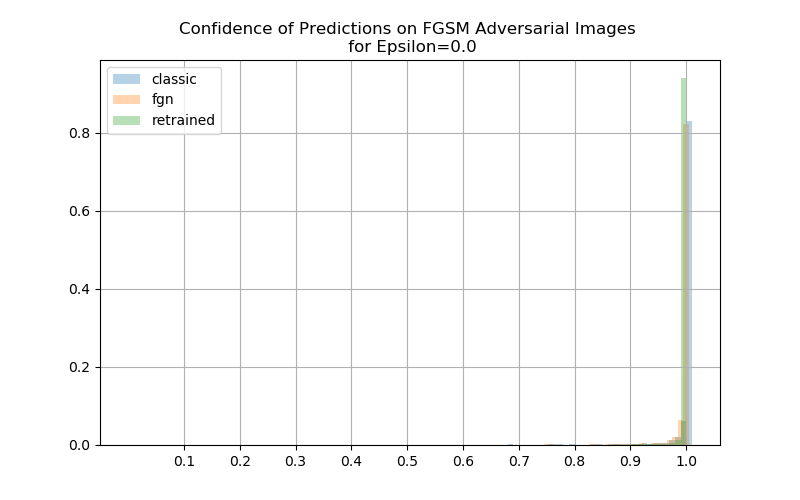

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


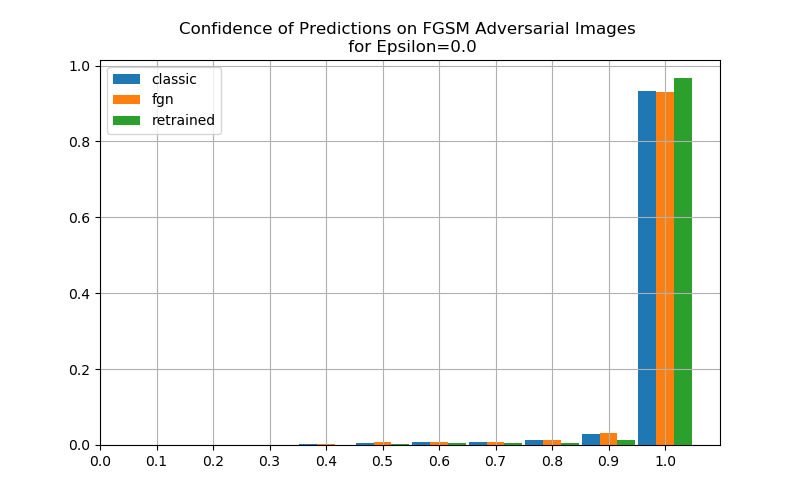

<IPython.core.display.Javascript object>


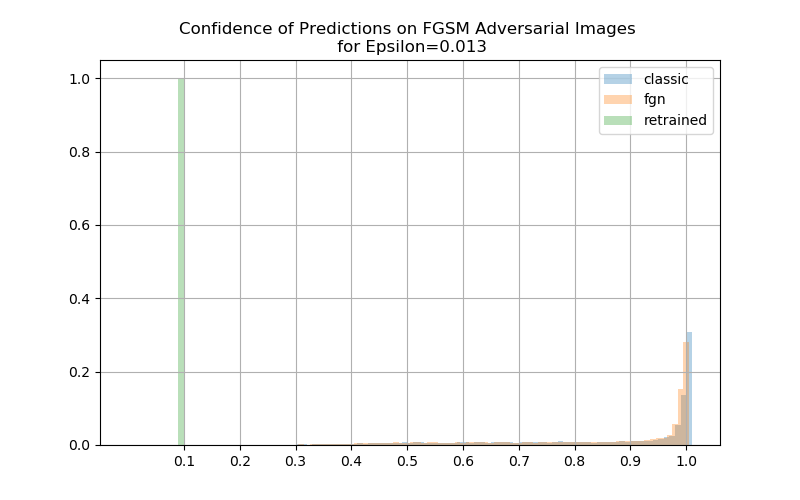

<IPython.core.display.Javascript object>


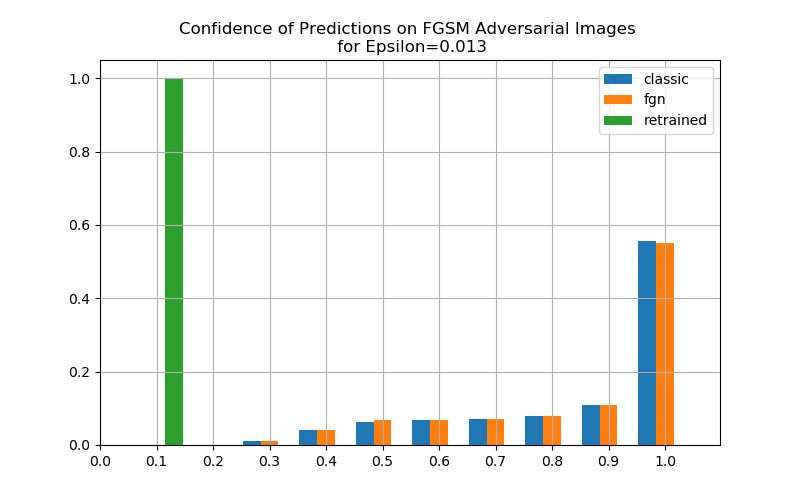

<IPython.core.display.Javascript object>


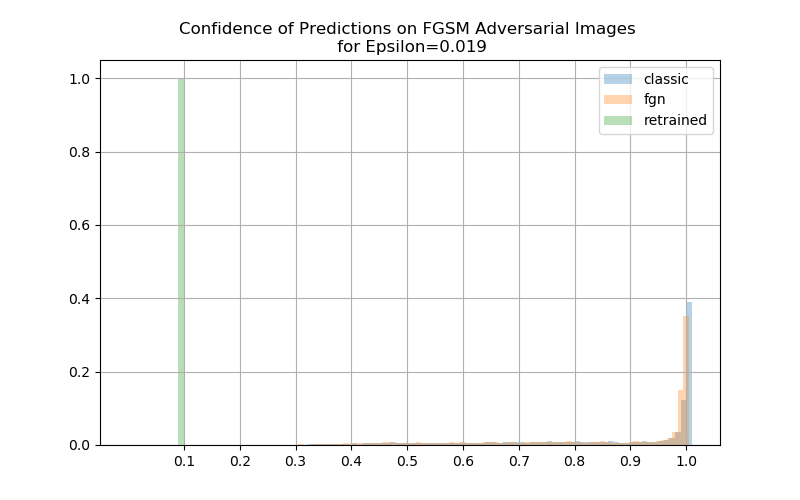

<IPython.core.display.Javascript object>


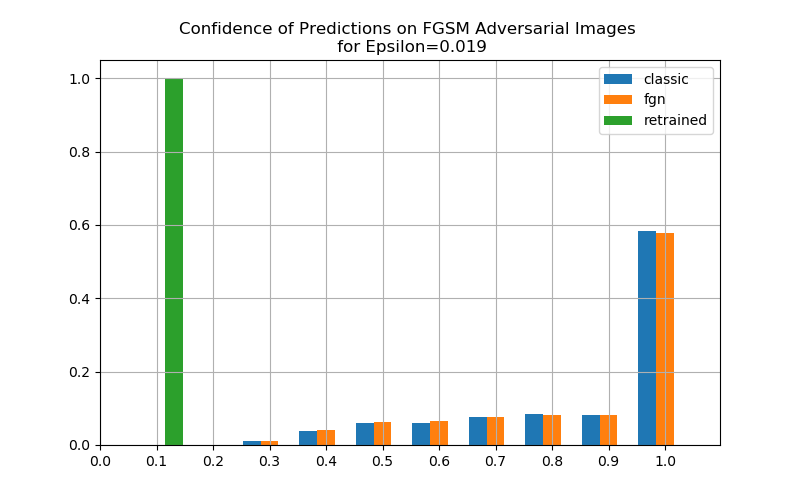

<IPython.core.display.Javascript object>


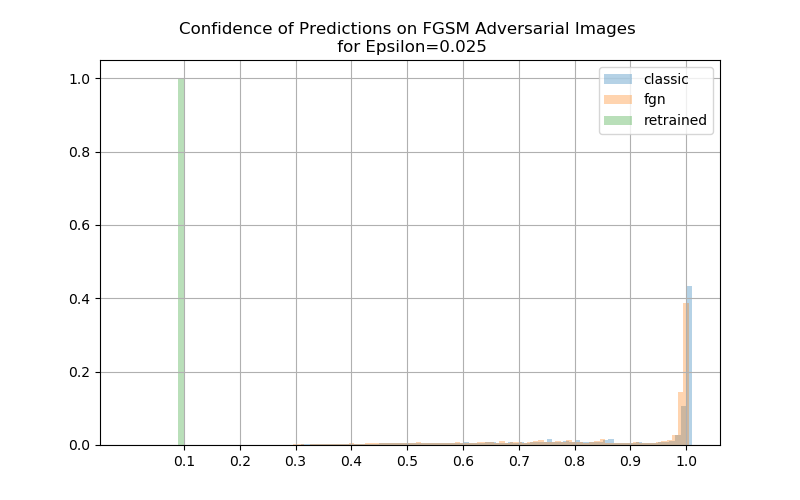

<IPython.core.display.Javascript object>


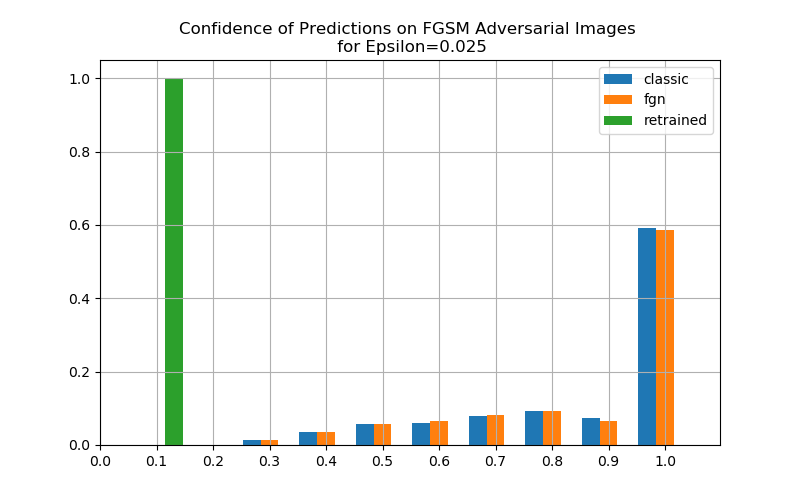

<IPython.core.display.Javascript object>


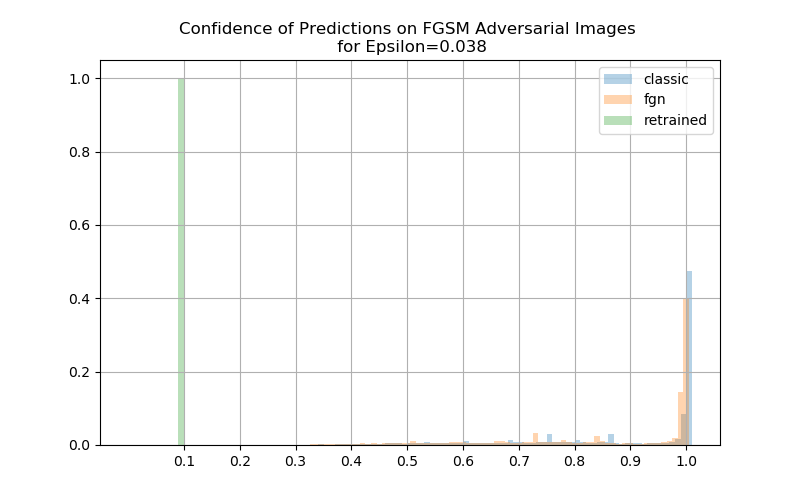

<IPython.core.display.Javascript object>


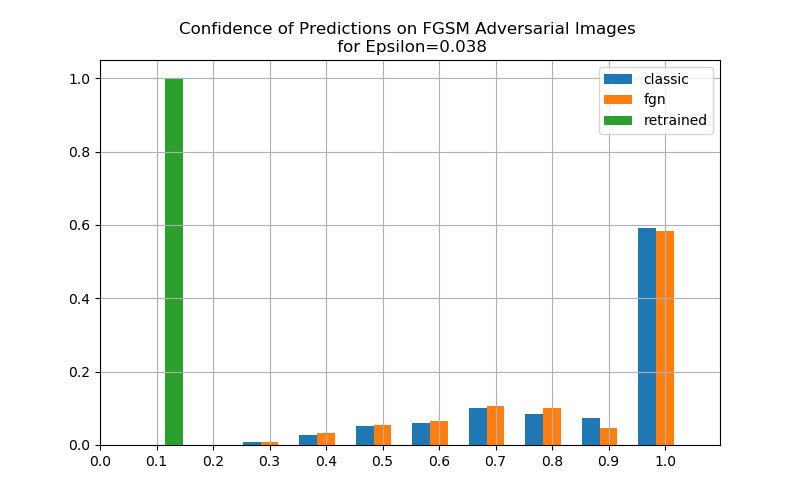

<IPython.core.display.Javascript object>


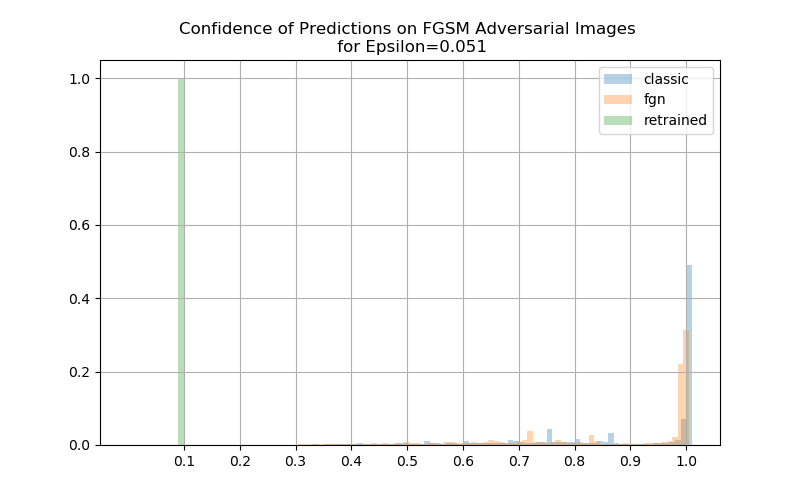

<IPython.core.display.Javascript object>


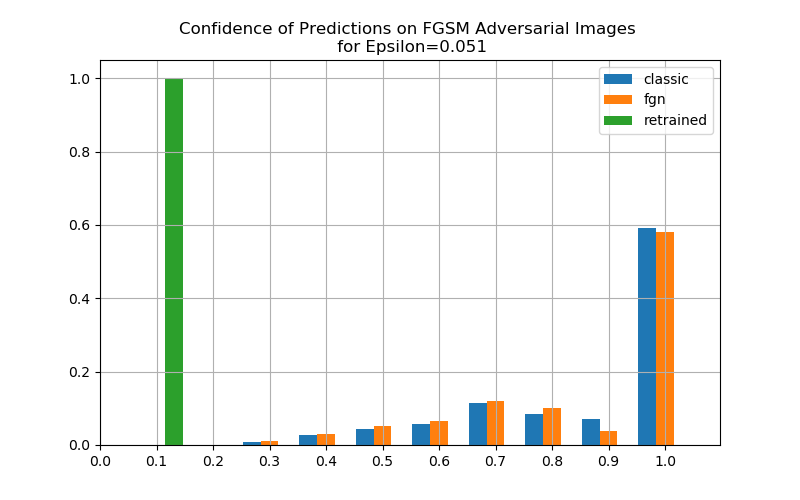

<IPython.core.display.Javascript object>


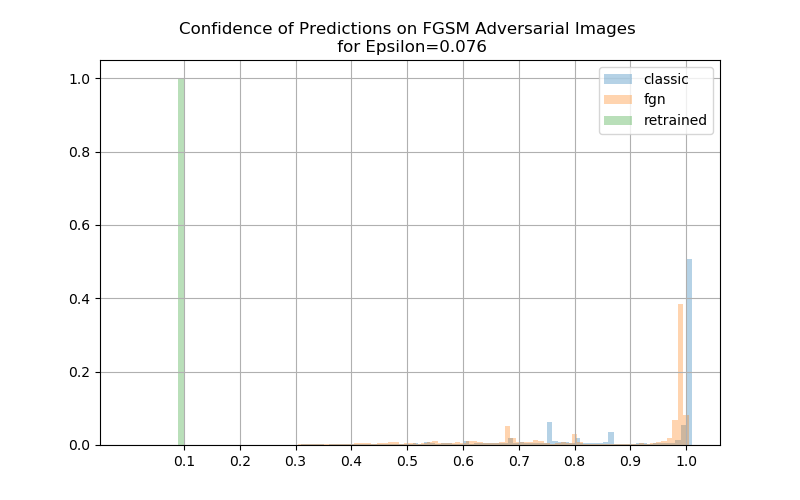

<IPython.core.display.Javascript object>


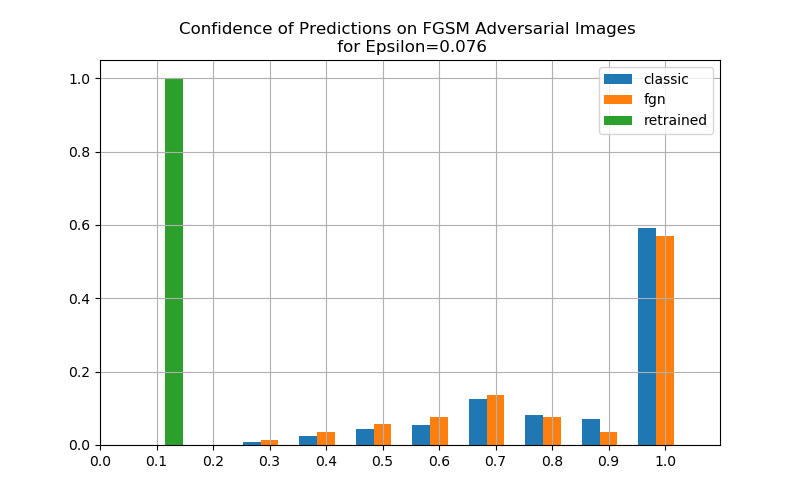

<IPython.core.display.Javascript object>


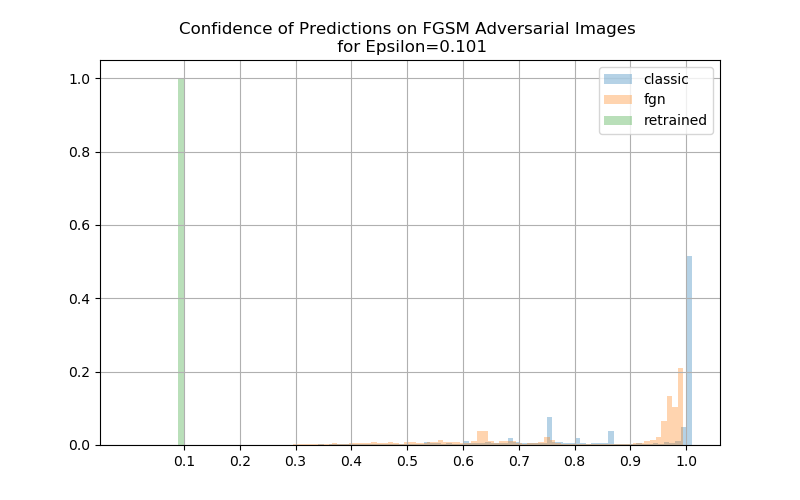

<IPython.core.display.Javascript object>


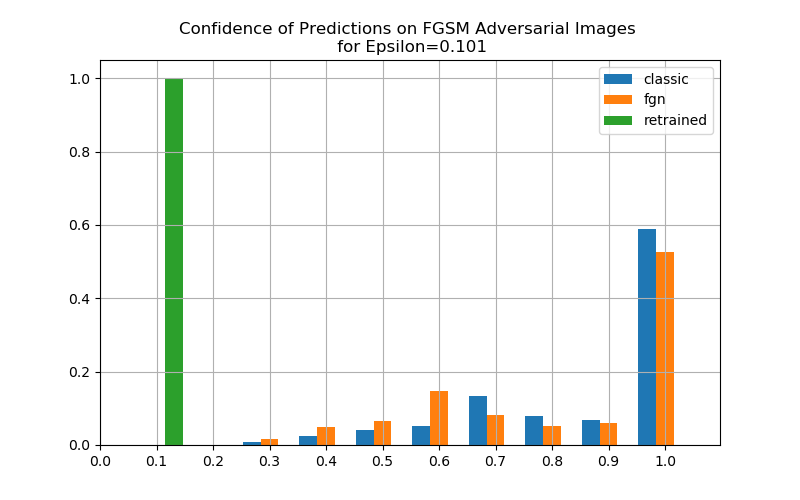

<IPython.core.display.Javascript object>


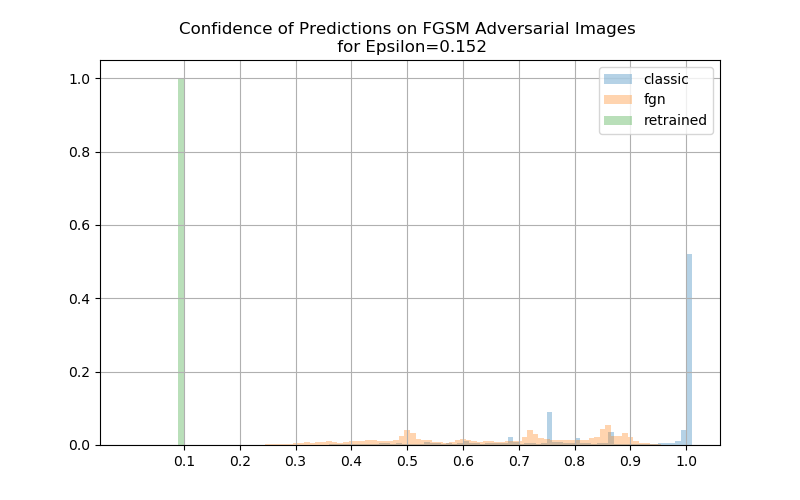

<IPython.core.display.Javascript object>


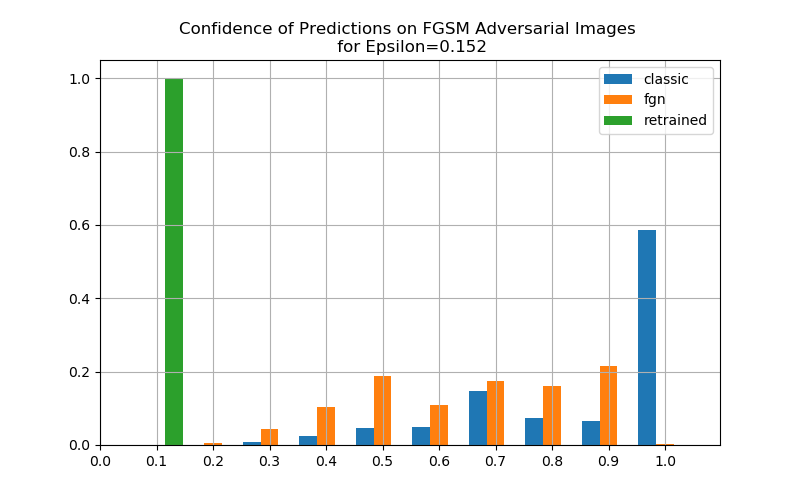

<IPython.core.display.Javascript object>


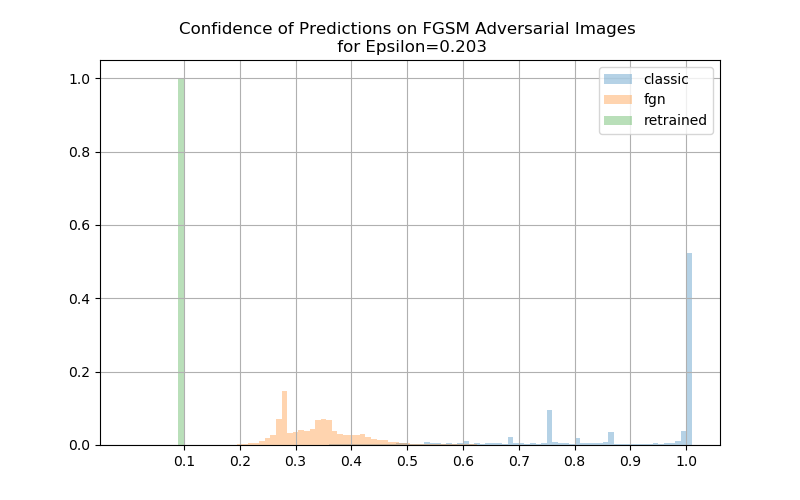

<IPython.core.display.Javascript object>


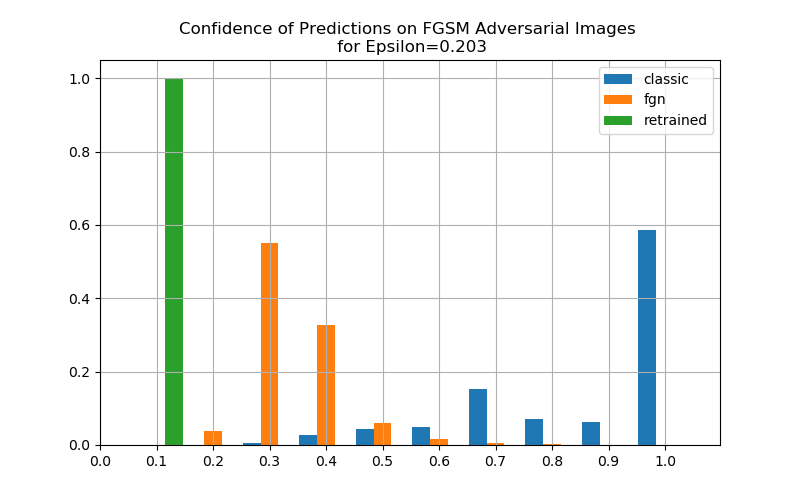

<IPython.core.display.Javascript object>


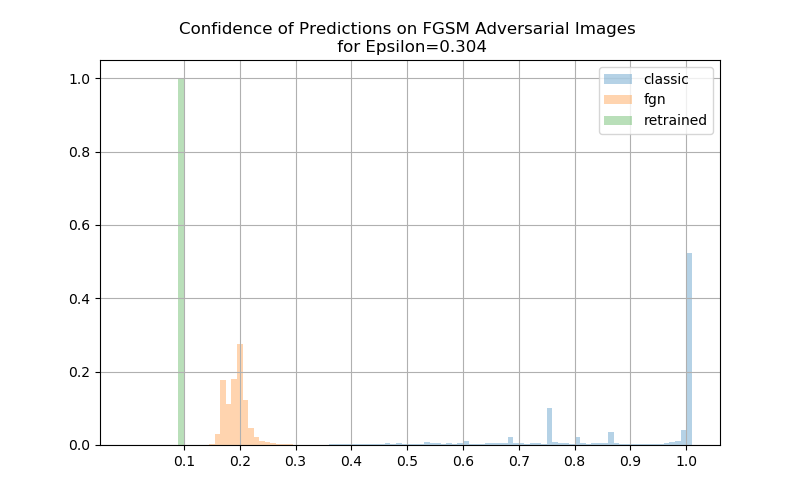

<IPython.core.display.Javascript object>


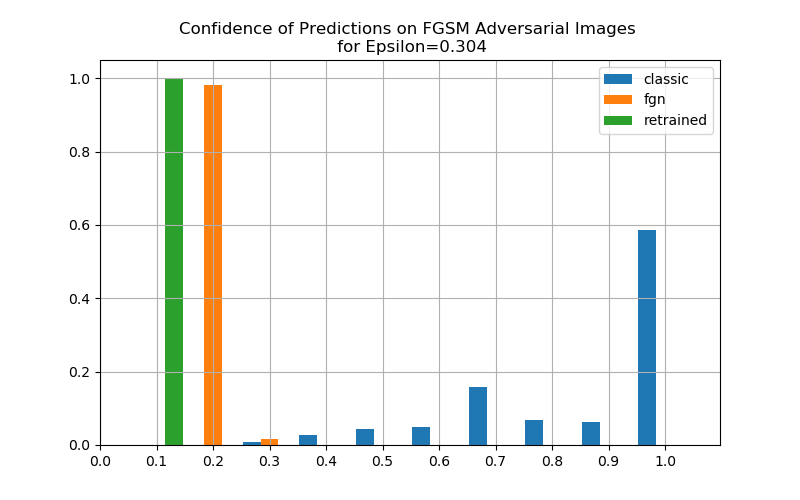

<IPython.core.display.Javascript object>


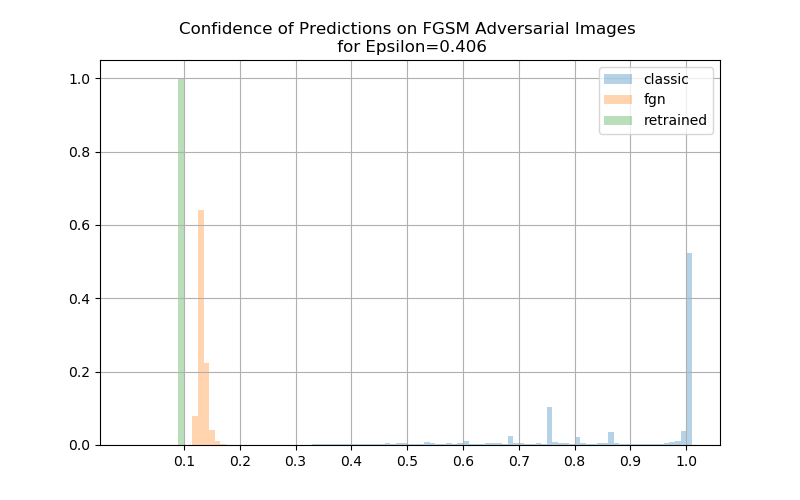

<IPython.core.display.Javascript object>


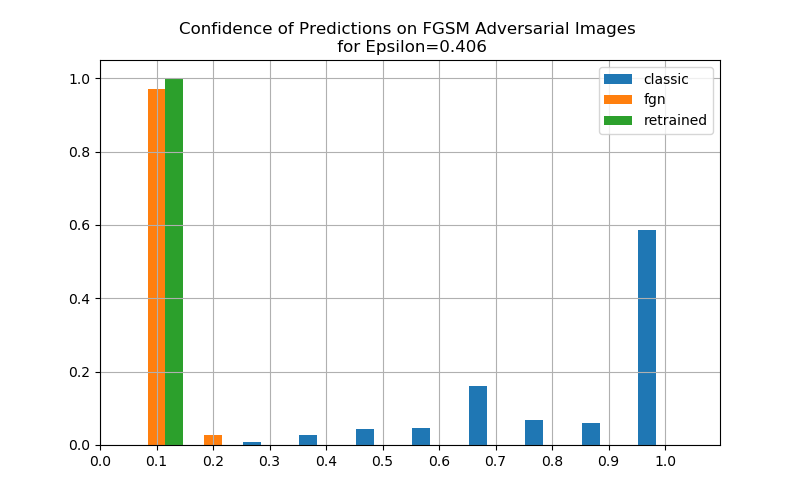

<IPython.core.display.Javascript object>


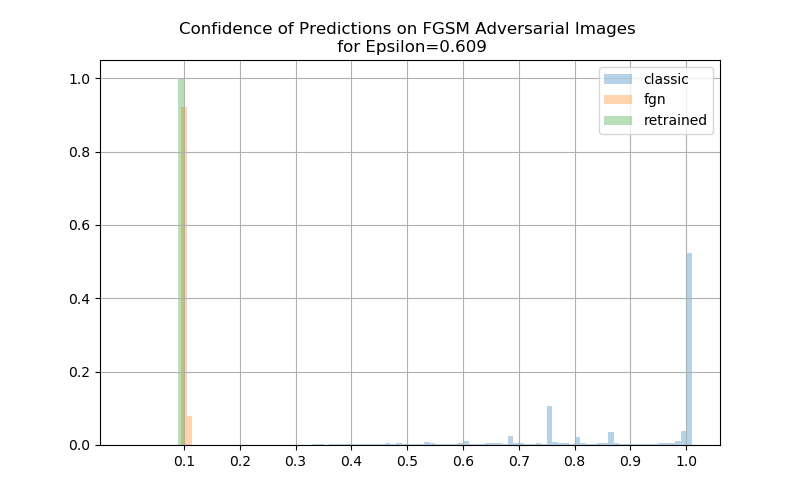

<IPython.core.display.Javascript object>


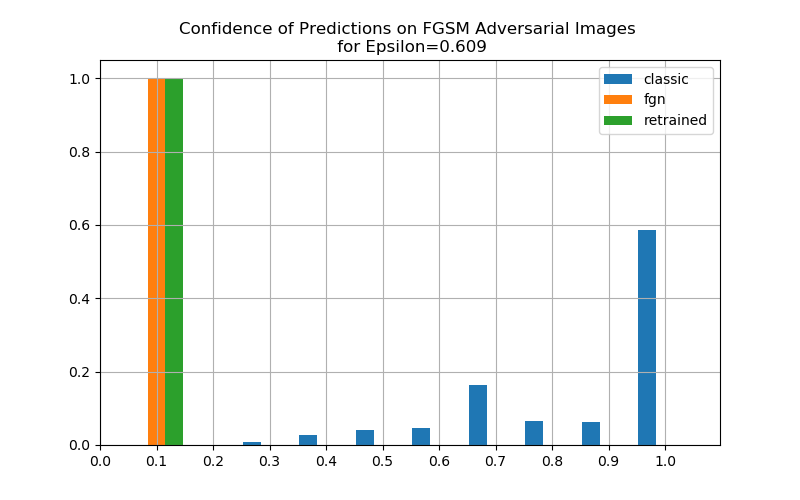

<IPython.core.display.Javascript object>


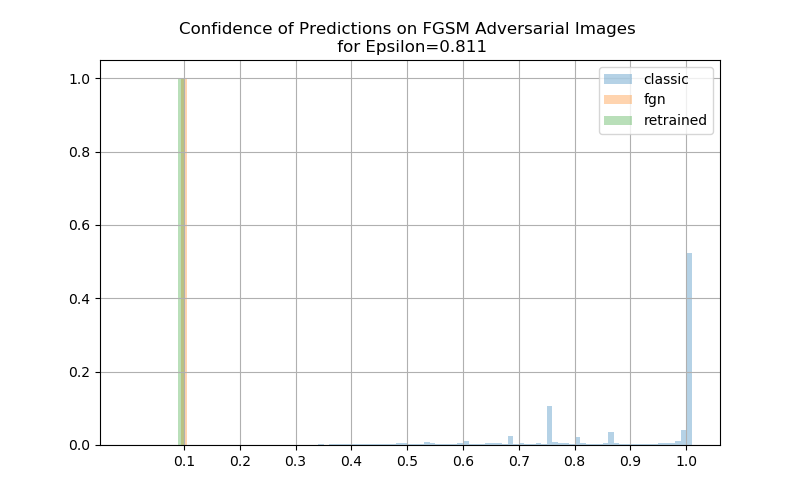

<IPython.core.display.Javascript object>


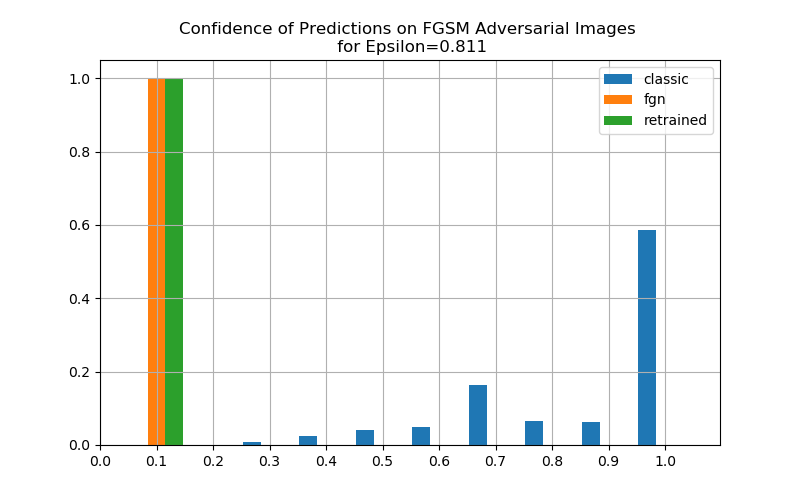

<IPython.core.display.Javascript object>


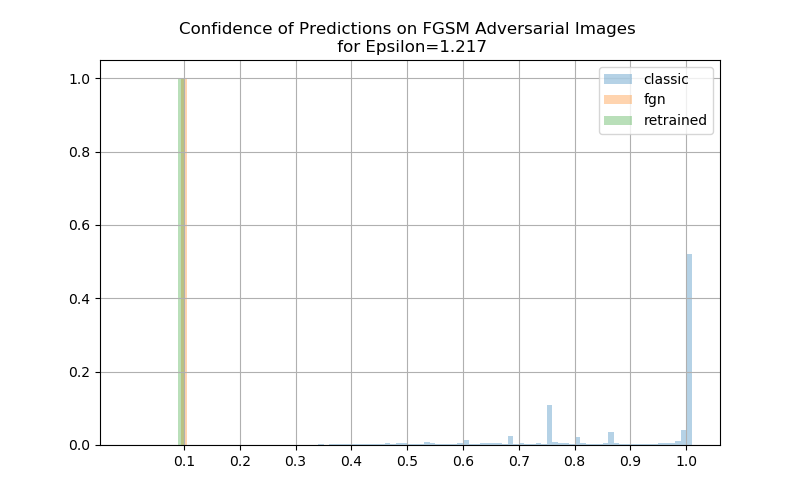

<IPython.core.display.Javascript object>


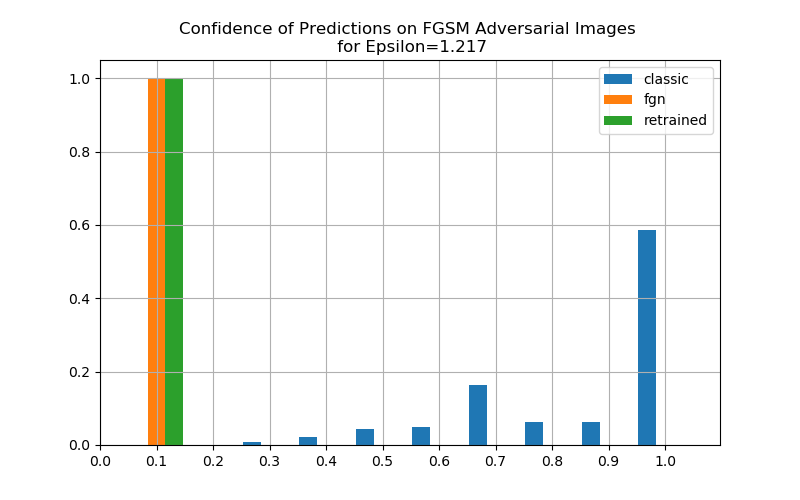

<IPython.core.display.Javascript object>


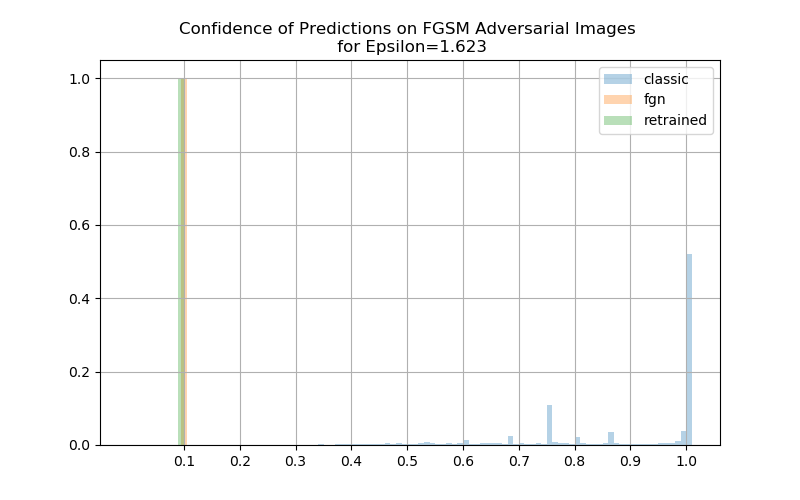

<IPython.core.display.Javascript object>


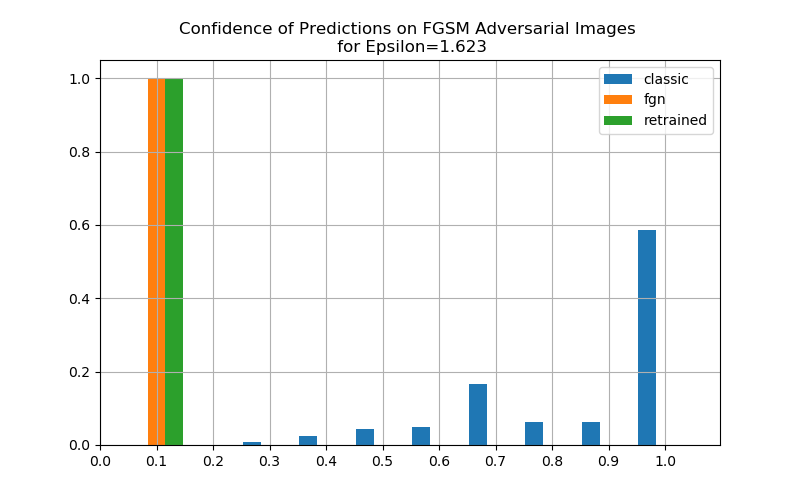

<IPython.core.display.Javascript object>


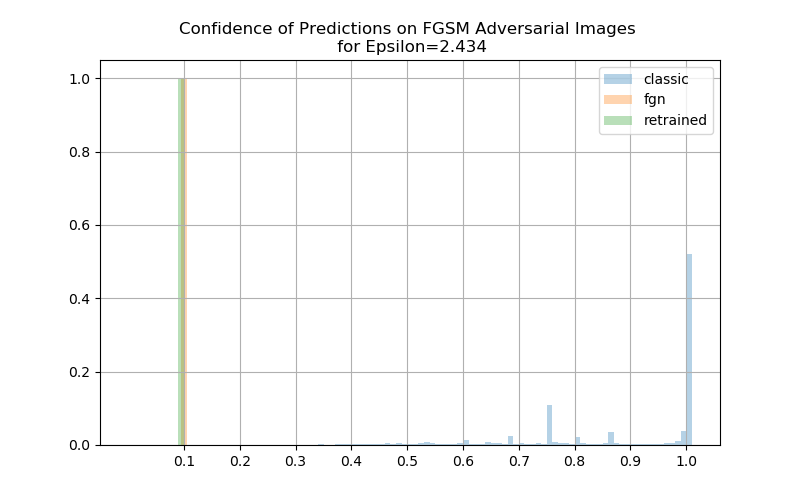

<IPython.core.display.Javascript object>


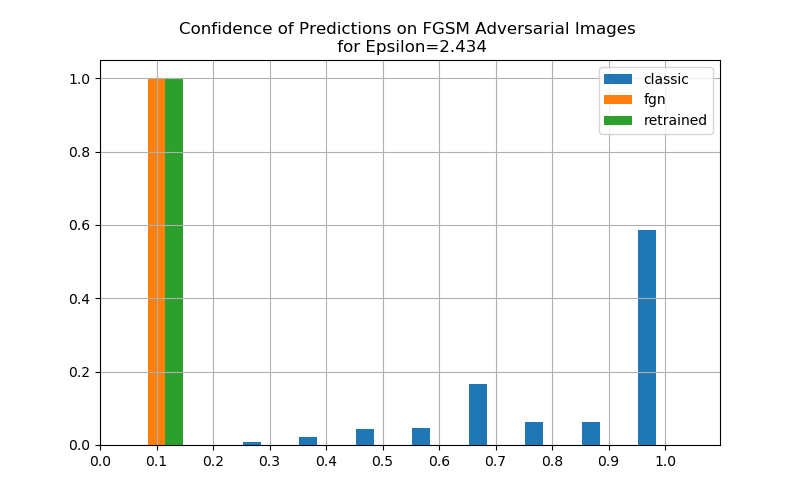

<IPython.core.display.Javascript object>


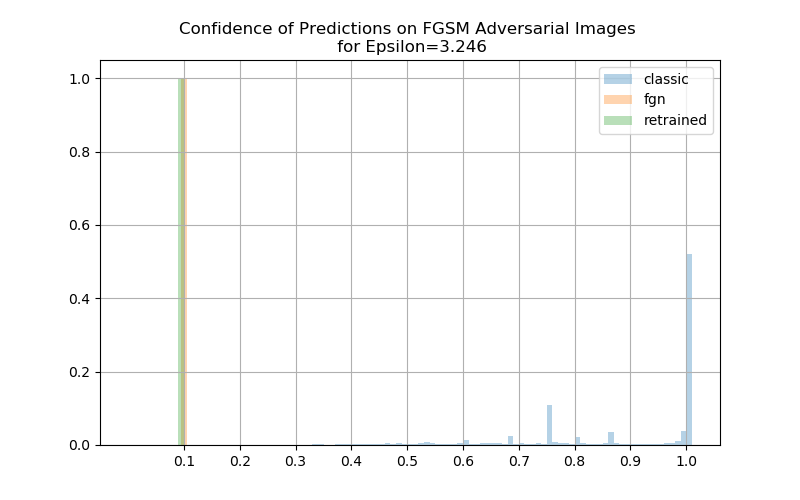

<IPython.core.display.Javascript object>


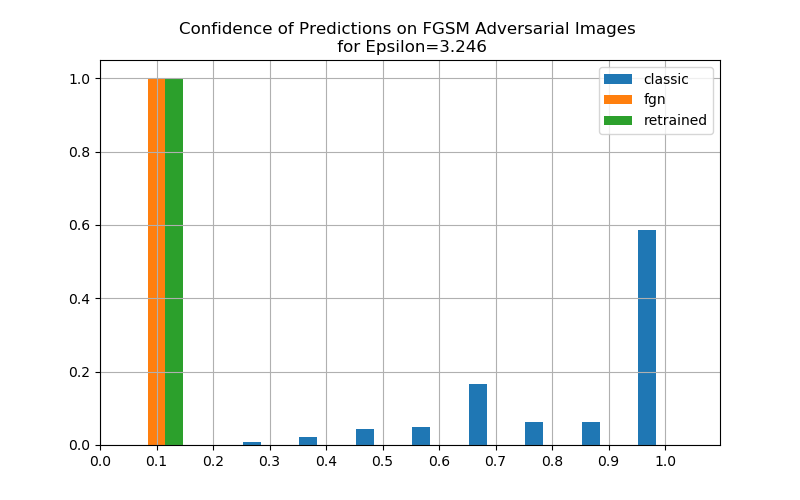

In [50]:
for i, clipped_images in enumerate(zip(classic_clipped, fgn_clipped, ret_fgn_clipped)):
    
    p = [] 
    for n, model in enumerate([classic_model, fgn_model, ret_fgn_model]):
        
        # compute predictions
        model.eval()
        with torch.no_grad(): preds = model(clipped_images[n].to(device))
        preds = preds.cpu().detach().numpy()
        
        # apply softmax for probabilities
        preds_softmax = np.array([np.exp(x)/sum(np.exp(x)) for x in preds.astype('float128')])
        # get the maximums
        preds_maxes = np.max(preds_softmax, axis=1)
        
        p.append(preds_maxes)
        
        # histogram
        plt.hist(preds_maxes,
                 bins=0.005+ np.arange(101)/100,
                 weights=[1/len(preds_maxes) for _ in preds_maxes], 
                 rwidth=1.2,
                 label=names[n],
                 align=al[n], 
                 alpha=0.33)
    plt.xticks((np.arange(10)+1)/10.0)
    plt.legend()
    plt.title('Confidence of Predictions on FGSM Adversarial Images \n for Epsilon={}'.format(np.round(epsilons[i],3)) )
    plt.grid(True)
    plt.show()
        
        
    # histogram
    # weights = np.ones_like(preds_maxes)/len(preds_maxes)
    plt.hist(p, bins= 0.05+ np.arange(11)/10,
             rwidth=0.95, weights=[[1/len(p[0]) for _ in p[0]] for _ in p],
             align='mid',
             label=names )
    plt.xticks(np.arange(11)/10.0)
    plt.legend()
    plt.title('Confidence of Predictions on FGSM Adversarial Images \n for Epsilon={}'.format(np.round(epsilons[i],3)) )
    plt.grid(True)
    plt.show()